# Import section

In [1]:
# python standard library
import json
import datetime as dt

# data science tools
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import DateOffset


# plotting tools
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# scikit-learn
from sklearn.neighbors import KernelDensity
from scipy.stats import pearsonr, ttest_ind, mannwhitneyu

# natural language processing tools
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('vader_lexicon')

# other helper tools
from tqdm import tqdm
from PIL import Image

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/fritt/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<br><br><br><br><br><br>
# SECTION 1: Initial analysis of Apple quotes
When searching for Apple quotes, we must discard food-related quotes while including quotes about Apple Inc. Therefore, we will use a rule-based approach, where we have a list of indicator words that decide whether to include a quotation. This way, we will be left with a filtered dataset containing mostly quotations related to the company Apple. This also enables us to utilize more extensive filtration algorithms, which would be too costly to run on the entire dataset. We have created a data preprocessing pipeline, which as a result has created a csv-file for each year, consisting only of Apple-related quotes.

Let's first load this data, as well as the relevant dates of the Apple product launches.


In [2]:
df_initial_analysis = pd.read_csv("data/quotes-2020-apple-filter.csv",sep=";")
df_initial_analysis = df_initial_analysis.append(pd.read_csv("data/quotes-2019-apple-filter.csv",sep=";"))
df_initial_analysis = df_initial_analysis.append(pd.read_csv("data/quotes-2018-apple-filter.csv",sep=";"))
df_initial_analysis = df_initial_analysis.append(pd.read_csv("data/quotes-2017-apple-filter.csv",sep=";"))
df_initial_analysis = df_initial_analysis.append(pd.read_csv("data/quotes-2016-apple-filter.csv",sep=";"))
df_initial_analysis = df_initial_analysis.append(pd.read_csv("data/quotes-2015-apple-filter.csv",sep=";"))
#List of dates for the apple events
apple_event_dates_str=["2015-03-09","2015-06-10","2015-09-09",
"2016-03-21","2016-06-15","2016-09-07", "2016-10-27",
"2017-06-07", "2017-09-12",
"2018-03-27","2018-06-06", "2018-09-12", "2018-10-30",
"2019-03-25","2019-06-05","2019-09-10","2019-12-02",
"2020-06-24","2020-09-15","2020-10-13","2020-11-10"]

#apple_event_dates_pd = pd.DataFrame({'Date':[dt.datetime.strptime(date, "%Y-%m-%d").date() for date in apple_event_dates_str]})
apple_event_dates=[dt.datetime.strptime(date, "%Y-%m-%d").date() for date in apple_event_dates_str]

In [3]:
df_initial_analysis

,quoteID,quotation,speaker,date,numOccurrences
0,2020-03-29-000118,... Zane Lowe checks in via FaceTime with Elto...,None,2020-03-29 17:47:52,1
1,2020-02-13-007205,Apple prices generally peak in January. Betwee...,Sarah Johnson,2020-02-13 10:01:48,3
2,2020-01-23-044076,"I'm not sure why Apple did this,",Roger Grimes,2020-01-23 17:15:24,2
3,2020-01-02-039024,new multi-year license agreement under which A...,None,2020-01-02 09:56:04,3
4,2020-01-19-037883,the best sort of deal they could have come up ...,Dickie Arbiter,2020-01-19 19:24:59,1
...,...,...,...,...,...
21483,2015-10-02-101639,"This is a mindset for permanent growth, becaus...",Terry Bell,2015-10-02 03:12:52,5
21484,2015-01-29-102007,We estimate [ that the pace of iPhone upgrades...,Andy Hargreaves,2015-01-29 17:52:13,3
21485,2015-05-18-003700,Apple has a world-class recycling program.,Tim Cook,2015-05-18 15:08:25,3
21486,2015-09-09-009615,"At the same time, those who purchase four pack...",Jason Teoh,2015-09-09 23:40:41,1


As seen above, we have gathered approximately 90.000 quotes from the quotebank data through 2015 to 2020. Lets start by investigating how the quote occurrences vary throughout the year

## How does the daily number of quotes vary throughout the year?

In [4]:
# Clean the date column, such that it only contains date information and not timestamp
df_initial_analysis['date_clean'] = df_initial_analysis.apply(lambda x: x['date'][:10],axis=1)

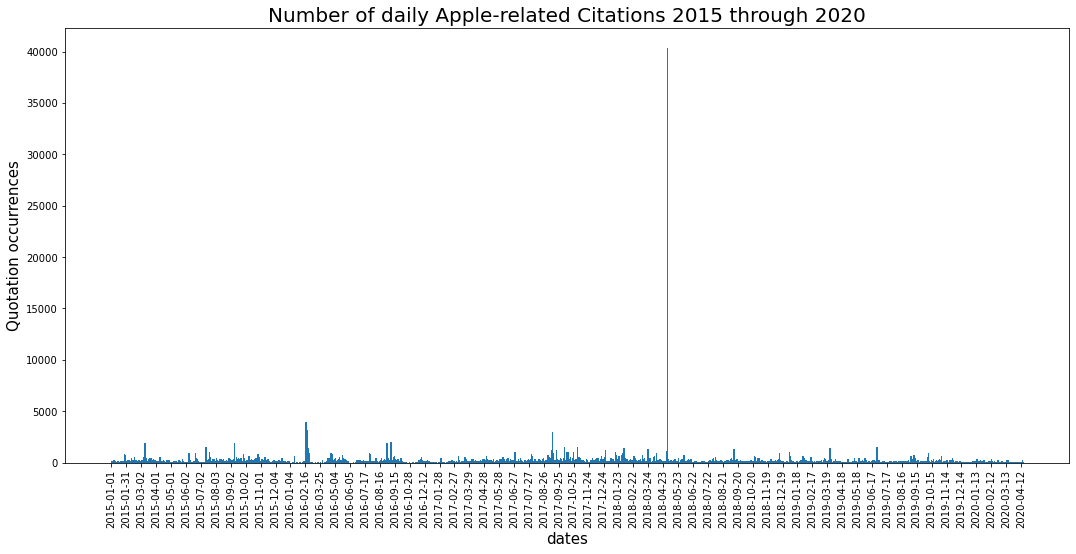

In [5]:
# Create plot to see the Apple-related quotes through the years
time = df_initial_analysis.groupby(['date_clean']).sum().index
quote_num = df_initial_analysis.groupby(['date_clean']).sum()['numOccurrences']
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(time,quote_num,width=3, align='center')
ax.set_xlabel("dates",size=15)
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=20)
plt.show()

We see a massive spike close to the date 2018-04-23, which seems rather suspicious. Let's investigate this further, by finding the particular quote and print its information.

In [6]:
# Print info about outlier quote
print(f"Quote occurrences: {df_initial_analysis.loc[df_initial_analysis.numOccurrences == df_initial_analysis.numOccurrences.max()].numOccurrences.item()} ")
print(f"Quote: {df_initial_analysis.loc[df_initial_analysis.numOccurrences == df_initial_analysis.numOccurrences.max()].quotation.item()}")

Quote occurrences: 39978 
Quote: Fortnite for iPhone is something of a gem in terms of content and its free-to-play structure.


It seems unlikely that such a generic quote has such a high occurrence number. There is the possibility that the quote originates from a viral tweet or advertisement, however, googling the quote yields no results. We will thus regard this as an extreme outlier for now, and investigate it further by comparing to the original data set in Milestone 3. 

In [7]:
# Drop outlier
df_initial_analysis = df_initial_analysis.drop(df_initial_analysis.loc[df_initial_analysis.numOccurrences == 39978].index)

Now that the outlier has been dropped, let's take a look at the plot again. 

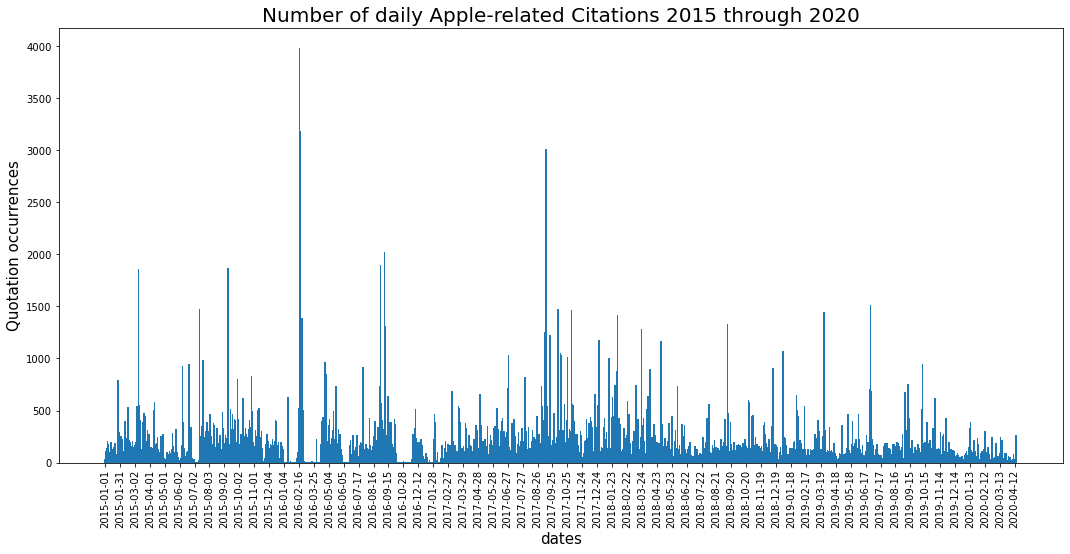

In [8]:
# Create plot to see the Apple-related quotes through the years (without outlier)
time = df_initial_analysis.groupby(['date_clean']).sum().index
quote_num = df_initial_analysis.groupby(['date_clean']).sum()['numOccurrences']
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(time,quote_num,width=3, align='center')
ax.set_xlabel("dates",size=15)
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=20)
plt.show()

This looks more reasonable. Let's try to look if any of the peaks occur at the same time as apple events

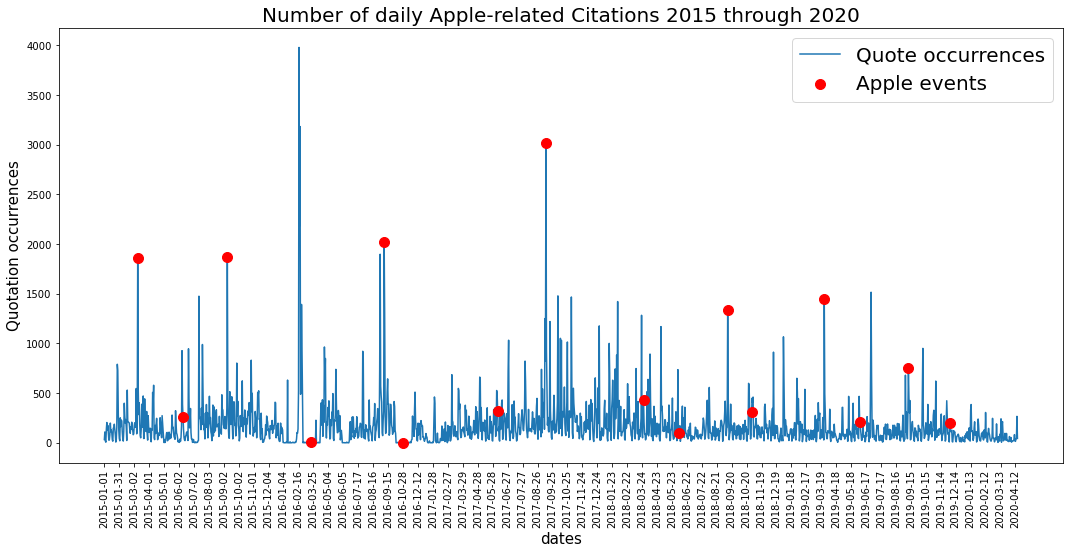

In [9]:
# add apple product launches as points
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(time,quote_num, label= "Quote occurrences")
ax.set_xlabel("dates",size=15)
ax.scatter(time[time.isin(apple_event_dates_str)],quote_num[time.isin(apple_event_dates_str)], c="r", s=100, zorder=3, label='Apple events')
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=20)
ax.legend(prop={'size': 20})
plt.show()


Many of the peaks are very close to Apple product launches. In Milestone 3 we will investigate this further.

## 3. How does the distribution of quote occurences look?

We will now take a quick glance at how the distribution of Apple quotes look.

Text(0.5, 1.0, 'Distribution of quote occurrences (Occurrences capped at 60)')

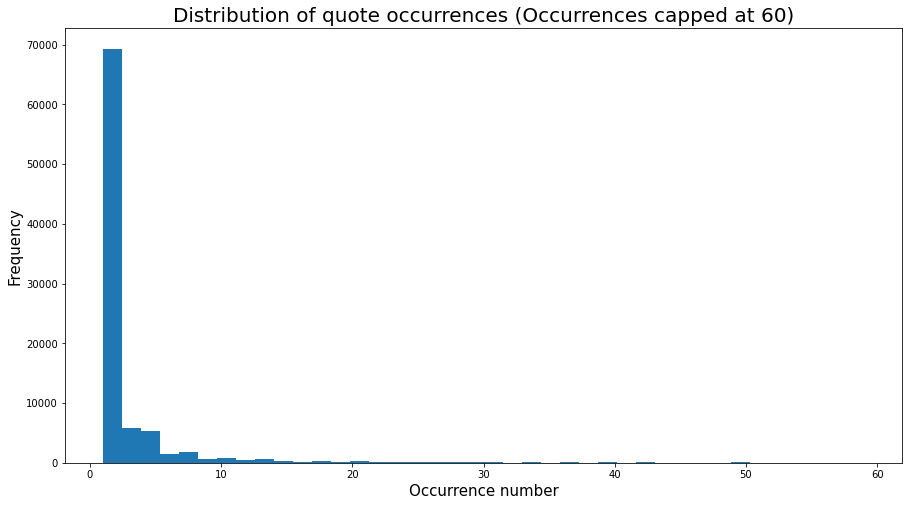

In [10]:
fig,ax = plt.subplots(figsize=(15,8))
ax.hist(df_initial_analysis.numOccurrences[df_initial_analysis.numOccurrences < 60],bins=40,);
ax.set_xlabel("Occurrence number",size=15)
ax.set_ylabel("Frequency",size=15)
ax.set_title("Distribution of quote occurrences (Occurrences capped at 60)",size=20)


As seen above, most of the quotes have been cited less than 10 times.

## 4. How does the most frequent speakers vary throughout the year?

### Investigation of frequent speakers

We will now investigate which speakers are the most cited when it comes to Apple. 


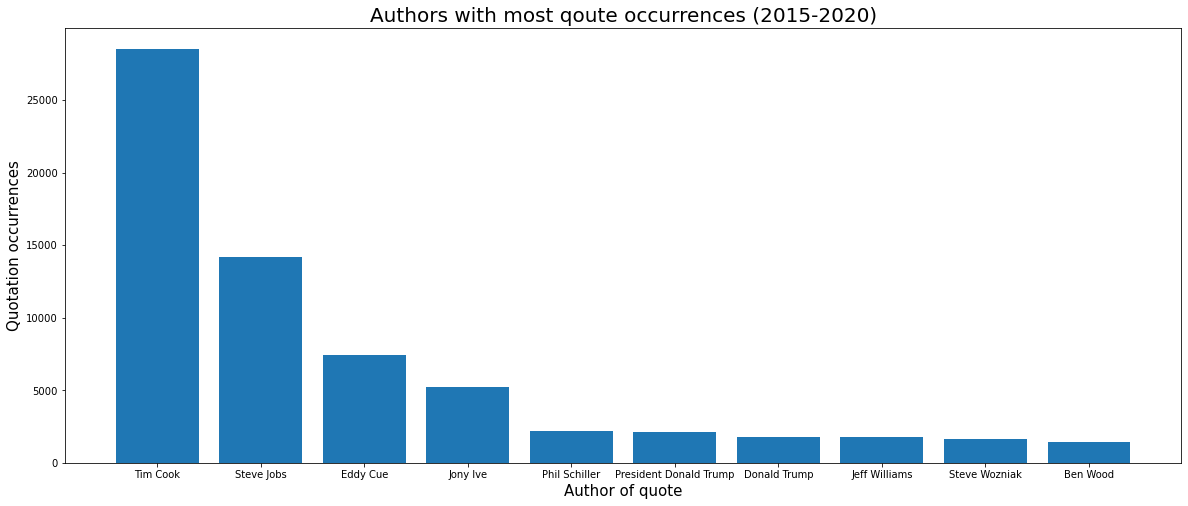

In [11]:
top_speakers = df_initial_analysis.loc[df_initial_analysis.speaker != 'None'].groupby(by=['speaker']).sum().sort_values(by='numOccurrences',ascending=False).reset_index()
fig,ax = plt.subplots(figsize=(20,8))
ax.bar(top_speakers.speaker[:10],top_speakers.numOccurrences[:10])
ax.set_xlabel("Author of quote",size=15)
ax.set_ylabel("Quotation occurrences",size=15)
#plt.xticks(top_speakers.speaker1[:10],rotation=90)
ax.set_title("Authors with most qoute occurrences (2015-2020)",size=20)
plt.show()

We see that Apple-related staff has the most quotes related to Apple e.g. Tim Cook, Steve Jobs, Eddy Cue, Jony Ive and Steve Wozniak. We now want to portray how this has evolved throughout the years. We will do this by making a column for each speaker. This enables us to plot the most active speakers over the period. Note that Donald Trump has several entries. The the code below will fix this as well.

In [12]:
#Extracting dataset and formatting date
quotes_per_date = df_initial_analysis.copy()
quotes_per_date['date'] = quotes_per_date['date'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d'))

#Extracting dataset and formatting date to show only month
quotes_per_month = df_initial_analysis.copy()
quotes_per_month['date'] = quotes_per_month['date'].apply(lambda x: dt.datetime.strptime(x[:7], '%Y-%m'))

#Pivoting table such that each column is a speaker and index is date
#Merging Donald Trump quotations and dropping None as well
quotes_per_date = quotes_per_date.pivot_table('numOccurrences', ['date'], 'speaker', fill_value=0, aggfunc=np.sum)
quotes_per_date['Donald Trump'] = quotes_per_date['Donald Trump'] + \
                                  quotes_per_date['President Donald Trump'] + \
                                  quotes_per_date['President Trump']
quotes_per_date.drop(['None', 'President Donald Trump', 'President Trump'], axis=1, inplace=True)

quotes_per_month = quotes_per_month.pivot_table('numOccurrences', ['date'], 'speaker', fill_value=0, aggfunc=np.sum)
quotes_per_month['Donald Trump'] = quotes_per_month['Donald Trump'] + \
                                   quotes_per_month['President Donald Trump'] + \
                                   quotes_per_month['President Trump']
quotes_per_month.drop(['None', 'President Donald Trump', 'President Trump'], axis=1, inplace=True)

#Cummulative representation of quotes
cummulative_quotes_per_date = quotes_per_date.cumsum(axis=0)
cummulative_quotes_per_month = quotes_per_month.cumsum(axis=0)

Due to visibility reasons we have chosen to only display the three most active speakers. 

Text(0, 0.5, 'Number of quotations')

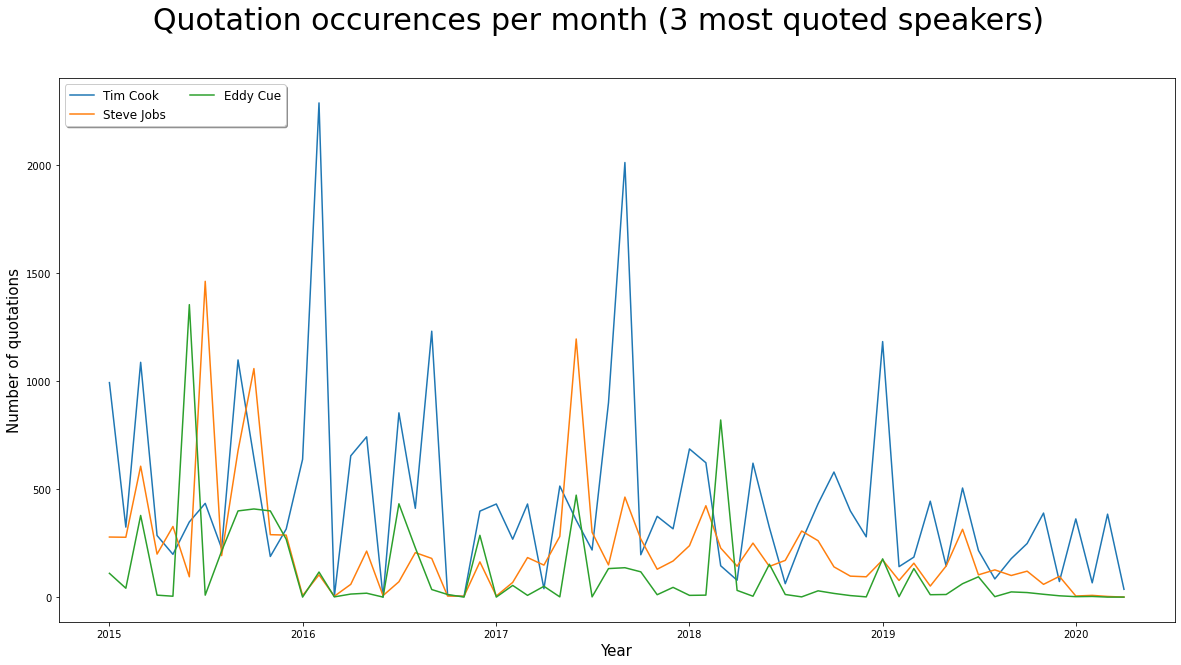

In [13]:
#Extract the 3 most frequent speakers
top_quoters = quotes_per_month.sum(axis=0).nlargest(3).index

#Extracting these from week dataset
top_quotes_per_month = quotes_per_month[top_quoters]
cummulative_top_quotes_per_month = cummulative_quotes_per_month[top_quoters]

fig = plt.figure(figsize=(20, 10))
labels=[]
for quoter in top_quoters:
    plt.plot(top_quotes_per_month.index, top_quotes_per_month[quoter])
    labels.append(quoter)

plt.legend(labels, ncol=2, loc='upper left', fancybox=True, shadow=True,
           fontsize=12)
fig.suptitle('Quotation occurences per month (3 most quoted speakers)', fontsize=30)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of quotations', fontsize=15)


In [14]:
top_quoters

Index(['Tim Cook', 'Steve Jobs', 'Eddy Cue'], dtype='object', name='speaker')

As seen above, each speaker has certain periods where they are quoted a lot, causing several spikes in the graph. To smooth this out we will plot the cumulative distribution over the same period.

Text(0, 0.5, 'Number of quotations')

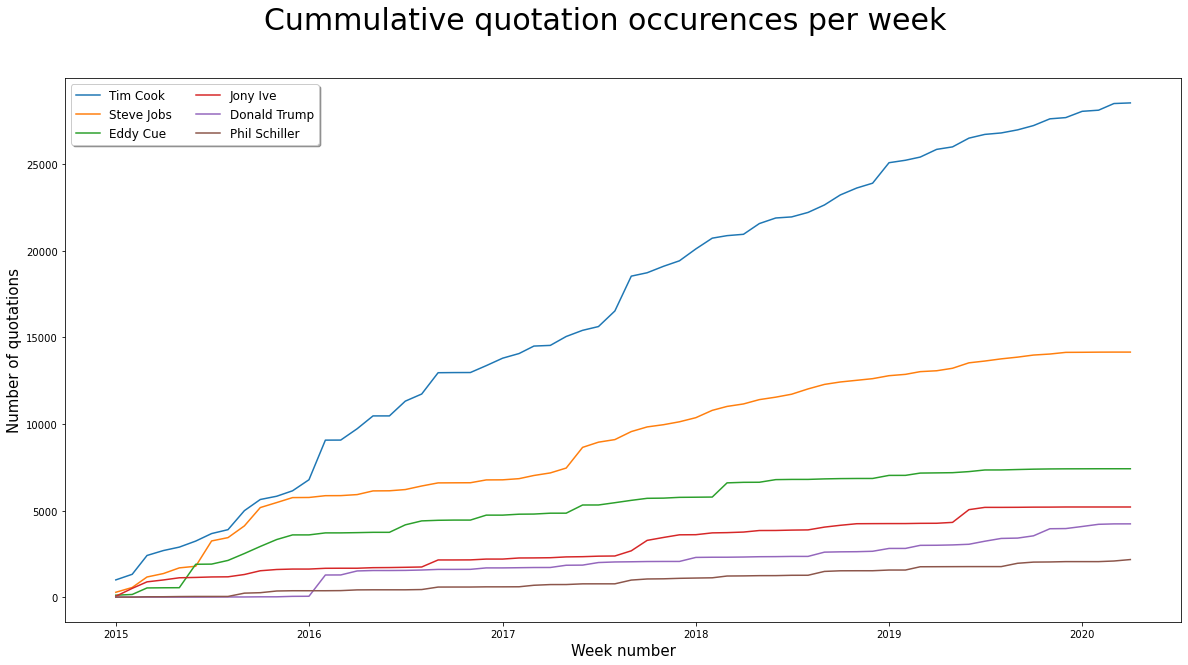

In [15]:
#Extract the 6 most frequent speakers
top_quoters = quotes_per_month.sum(axis=0).nlargest(6).index

#Extracting these from week dataset
top_quotes_per_month = quotes_per_month[top_quoters]
cummulative_top_quotes_per_month = cummulative_quotes_per_month[top_quoters]

fig = plt.figure(figsize=(20, 10))
labels=[]
for quoter in top_quoters:
    plt.plot(cummulative_top_quotes_per_month.index, cummulative_top_quotes_per_month[quoter])
    labels.append(quoter)

plt.legend(labels, ncol=2, loc='upper left', fancybox=True, shadow=True,
           fontsize=12)
fig.suptitle('Cummulative quotation occurences per week', fontsize=30)
plt.xlabel('Week number', fontsize=15)
plt.ylabel('Number of quotations', fontsize=15)



We immediately recognize the big names *Donald Trump*, *Tim Cook* and *Steve Jobs*. Although Steve Jobs has passed away, he frequently gets quoted in the media. In addition, *Jony Ive* is the former chief designer of Apple, whom left the company in 2019. *Eddy Cue* is the senior vice president of Apple, reporting to Tim Cook. So it is natural that these names appear. *Phil Schiller* is also an apple executive. We initially observe that the most frequent speakers of Apple are indeed a part of the company. Not very shocking.

The problem with the plot above is that it only shows the speakers with the most attributed quotes throughout the whole period. To get a more dynamic view over the whole period, we've made an animation which shows the most frequent speakers up to each point in time. This can be viewed in the README.

### Code for making a .mp4 file with the animation

In [16]:
def summary(values, ranks):
    total_quotes = int(round(values.sum(), -2))
    s = f'Total Quotes - {total_quotes:,.0f}'
    return {'x': .99, 'y': .05, 's': s, 'ha': 'right', 'size': 8}

In [17]:
# Determine whether to make mp4 visualization of most quoted speakers. NOTE: To run this code 'bar_chart_race' and 'ffmpeg' needs to be installed in the environment.
create_mp4 = False
if create_mp4:
    quotes_per_date_plot = bcr.bar_chart_race(cummulative_quotes_per_month, filename='quotes_per_date_plot.mp4',
                                          n_bars=10,
                                          filter_column_colors=True,
                                          period_length=1000,
                                          steps_per_period=20,
                                          bar_label_size=7,
                                          tick_label_size=7,
                                          title='Most frequently quoted speakers about Apple',
                                          period_fmt='%B %Y',  
                                          dpi=500,
                                          shared_fontdict={'family' : 'serif', 'color' : 'black', 'size':'8', 'weight': 'normal'},
                                          cmap='dark12',
                                          period_summary_func=summary)

    

---

## Initial analysis of Apple stock and events

Since a huge part of this project will be to compare the quote data with stock data, we will now look at the Apple stock data, events and quarterly earnings for Apple Inc. 
We start by loading in the data sets.

In [18]:
#Load stock data
stock_data_initial=pd.read_csv('./data/AAPL_2015_to_2020_yahoo_finance.csv')
stock_data_initial.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.745993,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,24.048859,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,24.051128,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.388378,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.325428,237458000
5,2015-01-09,28.167500,28.312500,27.552500,28.002501,25.352594,214798000
6,2015-01-12,28.150000,28.157499,27.200001,27.312500,24.727892,198603200
7,2015-01-13,27.857500,28.200001,27.227501,27.555000,24.947439,268367600
8,2015-01-14,27.260000,27.622499,27.125000,27.450001,24.852377,195826400
9,2015-01-15,27.500000,27.514999,26.665001,26.705000,24.177876,240056000


In [19]:
#Load quarterly earnings data
quarterly_earnings=pd.read_excel('./data/Earnings_Apple.xlsx')
quarterly_earnings.head(10)

,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise(%)
0,AAPL,Apple Inc,"Oct 26, 2022, 5 AMEST",-,-,-
1,AAPL,Apple Inc,"Jul 25, 2022, 5 AMEST",-,-,-
2,AAPL,Apple Inc,"Apr 26, 2022, 5 AMEST",-,-,-
3,AAPL,Apple Inc,"Jan 25, 2022, 5 AMEST",1.88,-,-
4,AAPL,Apple Inc.,"Oct 28, 2021, 12 AMEST",1.24,1.24,+0.32
5,AAPL,Apple Inc.,"Jul 27, 2021, 12 AMEST",1.01,1.3,+29.1
6,AAPL,Apple Inc.,"Apr 28, 2021, 12 AMEST",0.99,1.4,+41.84
7,AAPL,Apple Inc.,"Jan 27, 2021, 12 AMEST",1.41,1.68,+18.98
8,AAPL,Apple Inc.,"Oct 29, 2020, 12 AMEST",0.7,0.73,+4.29
9,AAPL,Apple Inc.,"Jul 30, 2020, 12 AMEST",0.51,0.65,+26.22


We see that the first 8 rows of the `quarterly_earnings` data frame are irrelevant for this study. We, therefore, remove those.
We also observe that the `quarterly_earnings` and `stock_data_initial` have a different format of their Date column. We need to change one of them to be able to compare the two columns.


In [20]:
#Remove the unnecessary rows in the quarterly_earnings
quarterly_earnings=quarterly_earnings.drop(index=[0,1,2,3,4,5,6,7])

#Change the format of the Earnings Date column to be able to compare it with the Stock dataframe
quarterly_earnings["Earnings Date"]=quarterly_earnings["Earnings Date"].map(lambda x: x.replace(", 12 AMEST", "").replace(",", ""))
quarterly_earnings["Earnings Date"]=quarterly_earnings["Earnings Date"].map(lambda x: dt.datetime.strptime(x, "%b %d %Y").strftime("%Y-%m-%d"))

We now create a new dataframe containing only stock data from earning dates.

In [21]:
#Compare Dates in the two dataframe, based on this we create a new dataframe
apple_earnings_and_stock_data=stock_data_initial[stock_data_initial.Date.isin(quarterly_earnings["Earnings Date"])]
apple_earnings_and_stock_data.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
1024,2019-01-29,39.062500,39.532501,38.527500,38.669998,37.539963,166348800
523,2017-01-31,30.287500,30.347500,30.155001,30.337500,28.556133,196804000
330,2016-04-26,25.977501,26.325001,25.977501,26.087500,24.151581,224064800
1467,2020-10-29,112.370003,116.930000,112.199997,115.320000,114.416039,146129200
715,2017-11-02,41.650002,42.125000,41.320000,42.027500,40.051891,165573600


In [22]:
#Create a new dataframe only containing stock data from Apple event-days
apple_event_and_stock_data=stock_data_initial[stock_data_initial.Date.isin(apple_event_dates_str)]
apple_event_and_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
44,2015-03-09,31.990000,32.392502,31.264999,31.785000,28.890726,354114000
109,2015-06-10,31.980000,32.334999,31.962500,32.220001,29.408445,156349200
172,2015-09-09,28.440001,28.504999,27.442499,27.537500,25.248312,340043200
305,2016-03-21,26.482500,26.912500,26.285000,26.477501,24.512644,142010800
365,2016-06-15,24.455000,24.602501,24.257500,24.285000,22.619728,117780800


In [23]:
#Create a new dataframe only containing stock data from Apple event-days
apple_event_and_stock_data=stock_data_initial[stock_data_initial.Date.isin(apple_event_dates_str)]
apple_earnings_and_stock_data=stock_data_initial[stock_data_initial.Date.isin(quarterly_earnings["Earnings Date"])]

In [24]:
#apple_event_and_stock_data.to_csv('./data/events_dates_with_stock_data.csv')
#apple_earnings_and_stock_data.to_csv('./data/earnings_dates_with_stock_data.csv')

## Add data to dates where the stock market is closed

In [25]:
stock_data_initial.head(3) 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.8475,27.860001,26.837500,27.332500,24.745993,212818400
1,2015-01-05,27.0725,27.162500,26.352501,26.562500,24.048859,257142000
2,2015-01-06,26.6350,26.857500,26.157499,26.565001,24.051128,263188400


We see that the `stock_data_initial` don't contain all dates due to bank holidays and weekends. This may create conflicts when we want to merge the quotes dataset with the `stock_data_initial`. We will therefore look into different solutions in solving this problem.
First we try to fill the left out dates with the last valid observation.

In [26]:
# Copy and fill missing dates
stock_data_with_closed_days=stock_data_initial.copy()
idx = pd.date_range('2015-01-02', '2020-12-31')
stock_data_with_closed_days.index = pd.DatetimeIndex(stock_data_initial.Date)
stock_data_with_closed_days = stock_data_with_closed_days.reindex(idx, method='ffill').reset_index()
stock_data_with_closed_days = stock_data_with_closed_days.drop(columns=['Date'])
stock_data_with_closed_days = stock_data_with_closed_days.rename(columns={"index": "Date"})

In [27]:
stock_data_with_closed_days.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.8475,27.860001,26.837500,27.332500,24.745993,212818400
1,2015-01-03,27.8475,27.860001,26.837500,27.332500,24.745993,212818400
2,2015-01-04,27.8475,27.860001,26.837500,27.332500,24.745993,212818400
3,2015-01-05,27.0725,27.162500,26.352501,26.562500,24.048859,257142000
4,2015-01-06,26.6350,26.857500,26.157499,26.565001,24.051128,263188400


We now see that all dates has observations in it.

We can then plot the event dates, quarterly earning dates and stock price to see if there is any correlation between the dates.

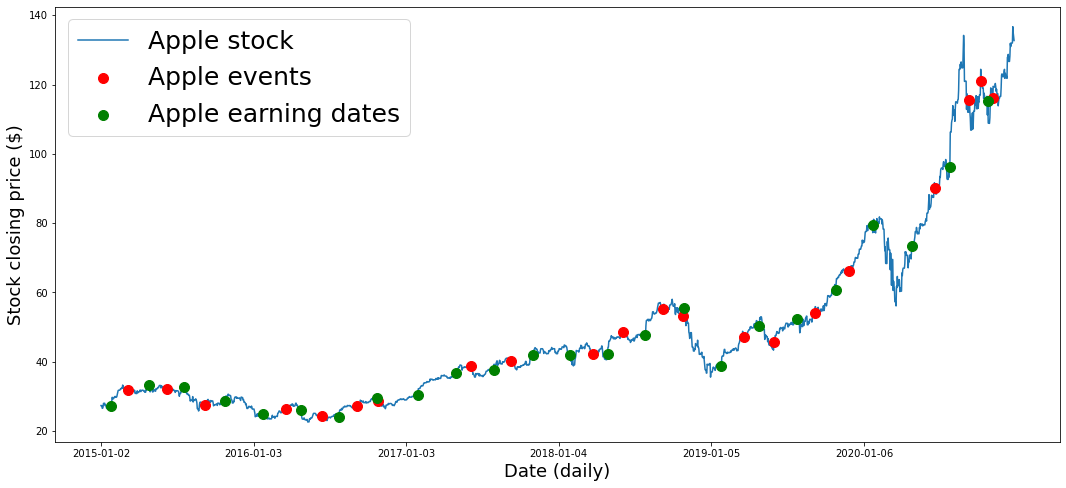

In [28]:
#Plots the dates after adding the 
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(stock_data_with_closed_days.Date,stock_data_with_closed_days.Close, label='Apple stock')
ax.set_xlabel("Date (daily)", size=18)
ax.set_ylabel('Stock closing price ($)', size=18)
plt.xticks(stock_data_with_closed_days.Date[::366])
ax.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Close, c="r", s=100, zorder=3, label='Apple events')
ax.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Close, c="g", s=100, zorder=3, label='Apple earning dates')
ax.legend(prop={'size': 25})
plt.show()

In addition we plot a graph with the trading volume for each day, to see if there are higher trading volumes around the event and quarterly earning dates.

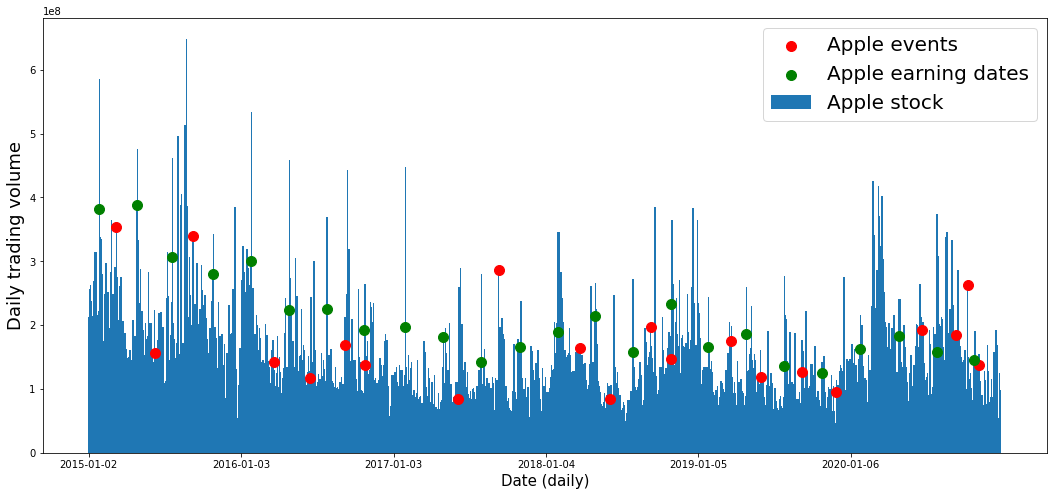

In [29]:
#Plot each trading day and its volume
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(stock_data_with_closed_days.Date,stock_data_with_closed_days.Volume, label='Apple stock', width=3, align='center')
ax.set_xlabel("Date (daily)",size=15)
ax.set_ylabel('Daily trading volume', size=18)
plt.xticks(stock_data_with_closed_days.Date[::366])
ax.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Volume, c="r", s=100, zorder=3, label='Apple events')
ax.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Volume, c="g", s=100, zorder=3, label='Apple earning dates')
ax.legend(prop={'size': 20})
plt.show()

Interestingly, it seems that some events occur in periods with high trading volume. In milestone 3 we want to investigate how this correlates to the media attention. 

## Group by week

Quote values may fluctuate heavily from day to day, and it is thus reasonable to aggregate in weeks. When comparing quote values to stocks, we thus need to be able to aggregate stock data on a weekly basis. Instead of imputing data into the `stock_data_initial`, we thus try to average the values per week. 

In [30]:
stock_data_weekly_average=stock_data_initial.copy()

#Create a new dataframe containing the weekly average of the stock price. The method is obtained from
stock_data_weekly_average.Date = pd.to_datetime(stock_data_weekly_average.Date) - pd.to_timedelta(7, unit='d')
stock_data_weekly_average = stock_data_weekly_average.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().reset_index().sort_values('Date')
stock_data_weekly_average.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-29,27.46000,27.511251,26.595000,26.947500,24.397426,234980200.0
1,2015-01-05,27.41200,27.683000,26.952000,27.358000,24.769084,214894240.0
2,2015-01-12,27.34375,27.558125,26.829375,27.051875,24.491926,254575800.0
3,2015-01-19,27.65450,28.030500,27.441000,27.837500,25.203208,203481600.0
4,2015-01-26,29.14100,29.448001,28.641500,28.957000,26.216769,378373440.0


We then plot the new graph.

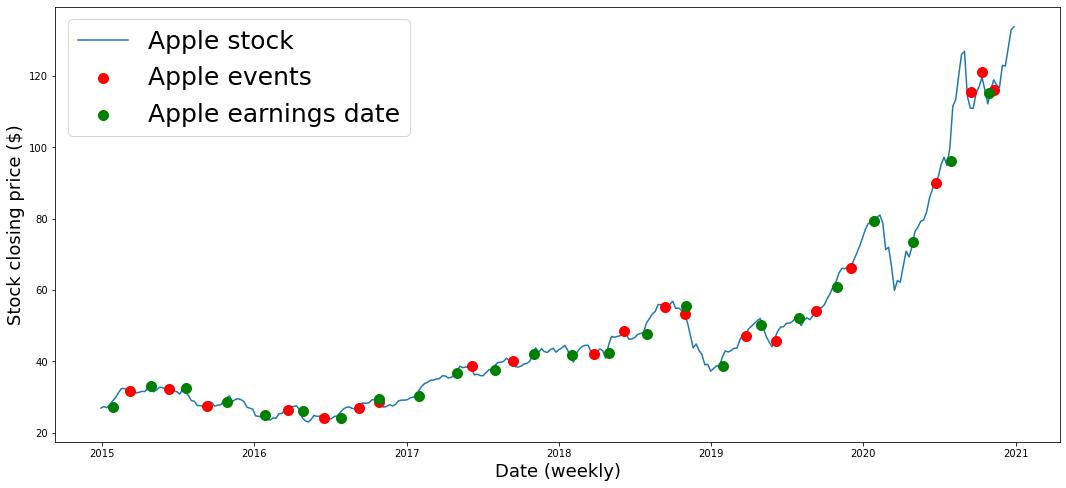

In [31]:
#Plots the weekly average
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(stock_data_weekly_average.Date,stock_data_weekly_average.Close, label='Apple stock')
apple_events=ax.set_xlabel("Date (weekly)",size=18)
ax.set_ylabel('Stock closing price ($)', size=18)
ax.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Close, c="r", s=100, zorder=3, label='Apple events')
ax.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Close, c="g", s=100, zorder=3, label='Apple earnings date')
ax.legend(prop={'size': 25})
plt.show();

<br><br><br><br><br><br><br><br>
# SECTION 2: Sentiment analysis of Apple quotes


## Part 1: Creating the sentiment dataframe
First we are extracting the apple data from the already filtered csv-files. These were created using the Extraction_of_relevant_apple_data.ipynb jupyter notebook.

In [ ]:
df_sentiment_analysis = pd.read_csv("data/quotes-2020-apple-filter.csv",sep=";")
df_sentiment_analysis = df_sentiment_analysis.append(pd.read_csv("data/quotes-2019-apple-filter.csv",sep=";"))
df_sentiment_analysis = df_sentiment_analysis.append(pd.read_csv("data/quotes-2018-apple-filter.csv",sep=";"))
df_sentiment_analysis = df_sentiment_analysis.append(pd.read_csv("data/quotes-2017-apple-filter.csv",sep=";"))
df_sentiment_analysis = df_sentiment_analysis.append(pd.read_csv("data/quotes-2016-apple-filter.csv",sep=";"))
df_sentiment_analysis = df_sentiment_analysis.append(pd.read_csv("data/quotes-2015-apple-filter.csv",sep=";"))

In [ ]:
df_sentiment_analysis.head()

Changing the dataframe columns to their appropriate data types.

In [ ]:
df_sentiment_analysis.quoteID = df_sentiment_analysis.quoteID.astype('string')
df_sentiment_analysis.quotation = df_sentiment_analysis.quotation.astype('string')
df_sentiment_analysis.speaker = df_sentiment_analysis.speaker.astype('string')
df_sentiment_analysis.numOccurrences = df_sentiment_analysis.numOccurrences.astype('int32')

In [ ]:
df_sentiment_analysis.dtypes

Sorting the dataframe by date so we get the correct order of the dataframes for the sentiment graph that will be created later

In [ ]:
df_sentiment_analysis = df_sentiment_analysis.sort_values('date')
df_sentiment_analysis.head()

For each row in the dataframe we will attach 4 new columns, neg, neu, pos and compound. These values are the negative, neutral, positive and compound values we get from the SentimentIntensityAnalyzer polary scores.

In [ ]:
# this cell takes 20 minutes to run, don't run it if not necessary.
# Run it ones and then read from csv

column_names = ['quoteID', 'quotation', 'speaker', 'date', 'numOccurrences','neg', 'neu', 'pos', 'compound']
    
sentiment_info_df = pd.DataFrame(columns = column_names)

print("Total number of rows: ", df_sentiment_analysis.shape[0])
for idx, row in tqdm(df_sentiment_analysis.iterrows()):
    
    # Calculating scores from SentimentIntensityAnalyzer
    new_row_dct = SentimentIntensityAnalyzer().polarity_scores(row['quotation'])
    
    # Creating and writing over value    
    new_row_dct['quoteID'] = row['quoteID']
    new_row_dct['quotation'] = row['quotation']
    new_row_dct['speaker'] = row['speaker']
    new_row_dct['date'] = row['date']
    new_row_dct['numOccurrences'] = row['numOccurrences']
    new_row = pd.DataFrame(new_row_dct, columns=column_names, index=[0])
    sentiment_info_df = sentiment_info_df.append(new_row)


We will also attach a date_clean column to the dataframe which only contains the date and not the timestamp.

In [ ]:
# Sorting by datetime
sentiment_info_df_sorted = sentiment_info_df.set_index('quoteID').sort_values('date')

# Clean the date column, such that it only contains date information and not timestamp
sentiment_info_df_sorted['date_clean'] = sentiment_info_df_sorted.apply(lambda x: x['date'][:10],axis=1)
sentiment_info_df_sorted.head()

We will save the current dataframe to csv since the analysis part takes around 20 minutes, so we don't have to redo that part each time we are going to change something in the notebook.

In [ ]:
#sentiment_info_df_sorted.to_csv('./data/sentiment_df.csv')

<br><br>
## Part 2: Sentiment analysis
Here we firstly read the dataframe from the csv and remove the fortnite outlier quote, which contains 39 978 occurences. This quote was decided to be removed in the exploratory part of the project.

In [32]:
# Read from csv to recreate a the fresh dataframe
sentiment_df = pd.read_csv('./data/sentiment_df.csv')
#finding index of outlier
print(sentiment_df[sentiment_df.numOccurrences == 39978])
#removing outlier
sentiment_df = sentiment_df.drop(58674)

Empty DataFrame
Columns: [Unnamed: 0, quoteID, quotation, speaker, date, numOccurrences, neg, neu, pos, compound, date_clean]
Index: []


**Raw datapoints visualized:**  
Firstly we will visualize the datapoints for positive and negative tweets.
- Green points: positive tweets
- Red points: negative tweets

This visualization is mainly to get a feeling of how to points are distributed, but it won't give us a lot of information straight away. It is just too much information for a human being to interpret, we will therefore make an aggregated graph based on the positive and negative points.


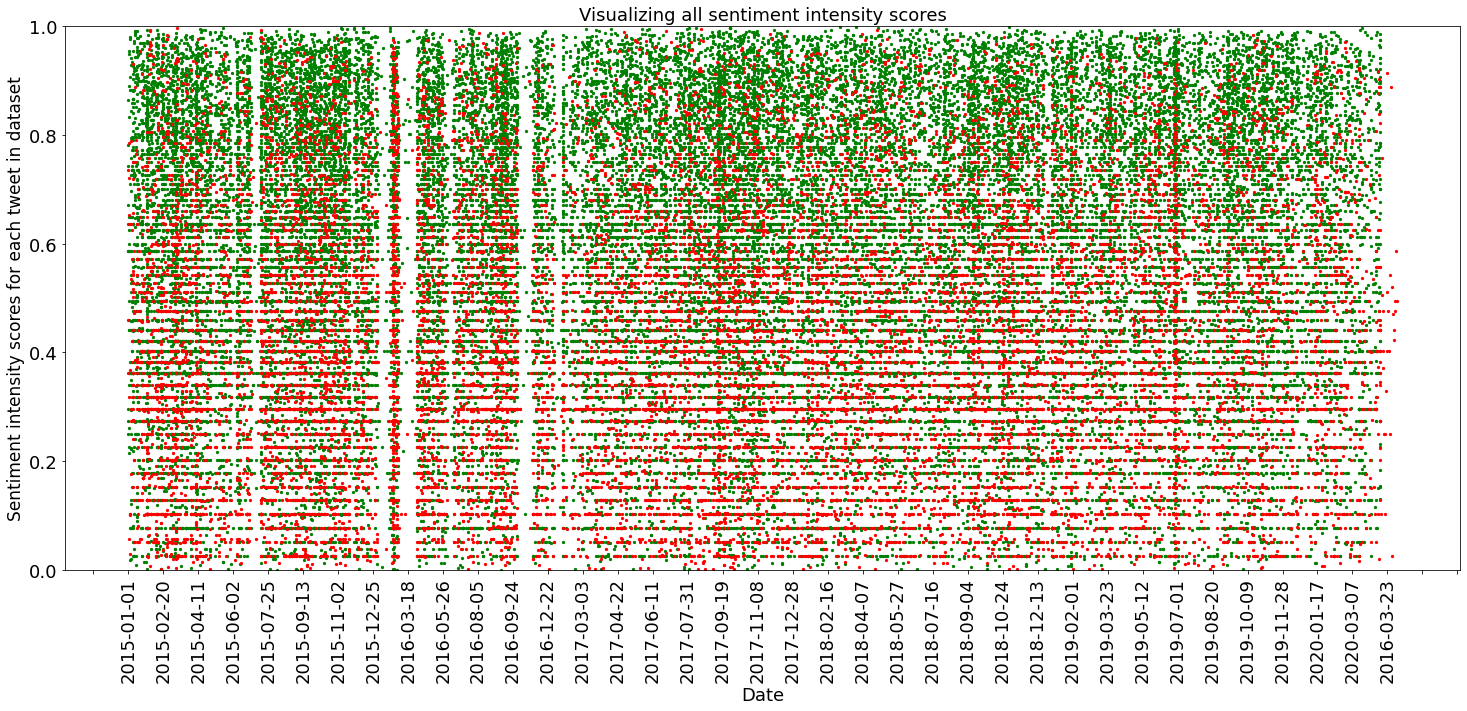

In [33]:
fig_sentiment_analysis,ax_sentiment_analysis = plt.subplots(figsize=(25,10))

cutoff_decimal = 0.0


pos_scores_df = sentiment_df[sentiment_df['compound'] > cutoff_decimal]
pos_scores = pos_scores_df['compound']
pos_dates = pos_scores_df['date_clean']

neg_scores_df = sentiment_df[sentiment_df['compound'] < -cutoff_decimal]
neg_scores = -neg_scores_df['compound']
neg_dates = neg_scores_df['date_clean']
ax_sentiment_analysis.set_ylim([0.0,1])
ax_sentiment_analysis.scatter(pos_dates, pos_scores, s=5, color='green')
ax_sentiment_analysis.scatter(neg_dates, neg_scores, s=5, color='red')

loc = plticker.MultipleLocator(base=50) # this locator puts ticks at regular intervals
ax_sentiment_analysis.xaxis.set_major_locator(loc)
plt.title('Visualizing all sentiment intensity scores', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sentiment intensity scores for each tweet in dataset', fontsize=17)
ax_sentiment_analysis.tick_params(axis='both', which='major', labelsize=18)
plt.xticks(rotation=90)
plt.show()

## 1 month aggregated sentiment intensity scores

Positive tweets will account for their value (given from SentimentIntensityAnalyzer) times +1 and times numOccurences.  
Negative tweets will account for their value (given from SentimentIntensityAnalyzer) times -1 and times numOccurences. 

In [34]:
agg_month_sentiment = []
agg_month_dates = []

for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_month = date[:7]
        current_size = 0


    tmp_month = current_month
    current_month = date[:7] # the seven first digits of the date
    if tmp_month != current_month:
        agg_month_sentiment.append(current_size)
        current_size = 0
        agg_month_dates.append(current_month)
    
    # updates weighted aggregated value of positive and negative
    
    current_size += row['compound']*row['numOccurrences']

    
    

**For the datastory:**
For our sentiment analysis, we have labeled every quote in our apple dataset with a sentiment compound score between -1.0 and 1.0. Since there are too many quotes to represent visually, we have aggregated quote scores for each month and visualized the aggregated score for that month. These calculations heavily depend on the sentiment tool, so to secure that we don't include neutral quotes or quotes that the tool is hesitant about, we have made an arbitrarily cutoff of 0.6. Therefore, the graph will not include sentiment intensity scores between -0.6 and 0.6 in the calculations.

Comments on the graph: As we can see by the chart there seems to be a disproportionate balance between positive and negative quotes since most months, the aggregated score is far above 0. We can also see a reduction in sentiment intensity scores from late 2019 until early 2020 - which may be caused by covid-19.

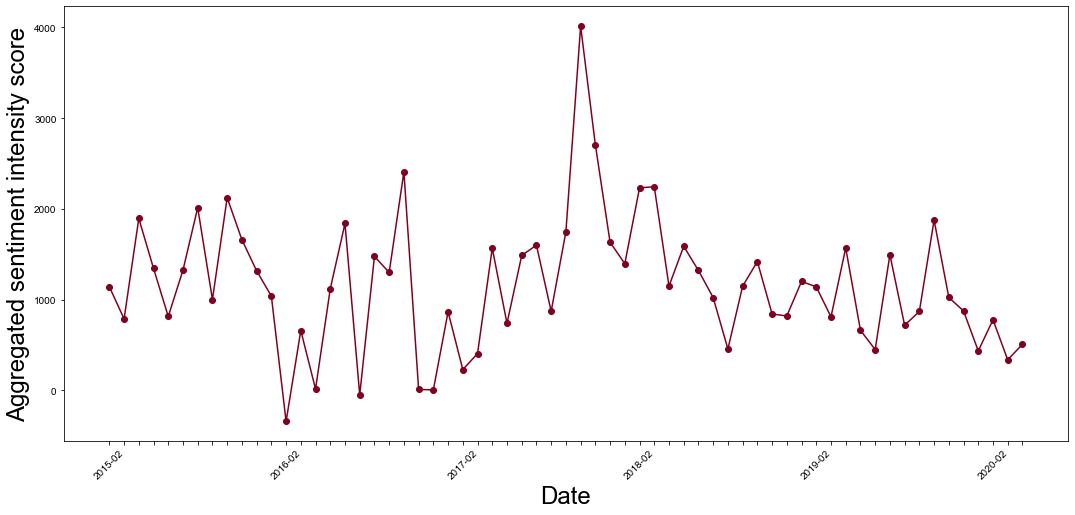

In [35]:
fig_1_sentiment, ax_1_sentiment = plt.subplots(figsize=(18,8))
result_values = []
result_mon = []
for mon, agg in zip(agg_month_dates, agg_month_sentiment):
    result_values.append(agg)
    result_mon.append(mon)

sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False},
              font_scale=1.8, font="PT Sans")


ax_1_sentiment.plot(result_mon, result_values, '-o', color='#800020')
#plt.title('1 month aggregation scores for tweets', fontsize=18)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Aggregated sentiment intensity score', fontsize=24)

#ax_1_sentiment.plot(agg_month_dates, agg_month_sentiment)
plt.xticks(rotation=45);
for n, label in enumerate(ax_1_sentiment.xaxis.get_ticklabels()):
    if n % 12 != 0:
        label.set_visible(False)

## 1 month aggregated and weighted sentiment intensity scores (based on speaker)
**Name list - multiplicative weight:**
1. Tim Cook  - 2.0
2. Steve Jobs - 1.9
3. Eddy Cue - 1.8
4. Jony Ive - 1.7
5. Donald Trump - 1.6
6. Phill Schiller - 1.5
7. Jeff Williams - 1.4
8. Steve Wozniak - 1.3
9. Ben Wood  -  1.2
10. Brian White  - 1.1

Based on our "Most frequently quoted speakers about Apple" bar chart race, we will give quotes that has a speaker to any of the people from the top 10 list some additional weight. 

In [36]:
speaker_weights = {
    "Tim Cook": 2,
    "Steve Jobs": 1.9,
     "Eddy Cue" : 1.8,
     "Jony Ive" : 1.7,
     "Donald Trump" : 1.6,
     "Phill Schiller" : 1.5,
     "Jeff Williams" : 1.4,
     "Steve Wozniak" : 1.3,
     "Ben Wood" : 1.2,
     "Brian White" : 1.1,
}

In this code block we do the same as we did in the one above, the only difference is that we scale the datapoint if it is included in the speaker weights dictionary.

In [37]:
agg_month_speaker_weight_sentiment = []
agg_month_speaker_weight_dates = []

for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    speaker = row['speaker']
    if index == 0:
        current_speaker_weight_month = date[:7]
        current_speaker_weight_size = 0


    tmp_speaker_weight_month = current_speaker_weight_month
    current_speaker_weight_month = date[:7] # the seven first digits of the date
    if tmp_speaker_weight_month != current_speaker_weight_month:
        agg_month_speaker_weight_sentiment.append(current_speaker_weight_size)
        current_speaker_weight_size = 0
        agg_month_speaker_weight_dates.append(current_speaker_weight_month)
    
    speaker_mult = 1
    if speaker in speaker_weights:
        speaker_mult = speaker_weights[speaker]
        
    # updates weighted aggregated value of positive and negative
    if abs(row['compound']) > 0.6:
        current_speaker_weight_size += row['compound']*row['numOccurrences']*speaker_mult

    
    

Here we have the 1 month aggregations scores which are multiplied by the speaker weights, which gives extra weight to the important speakers.

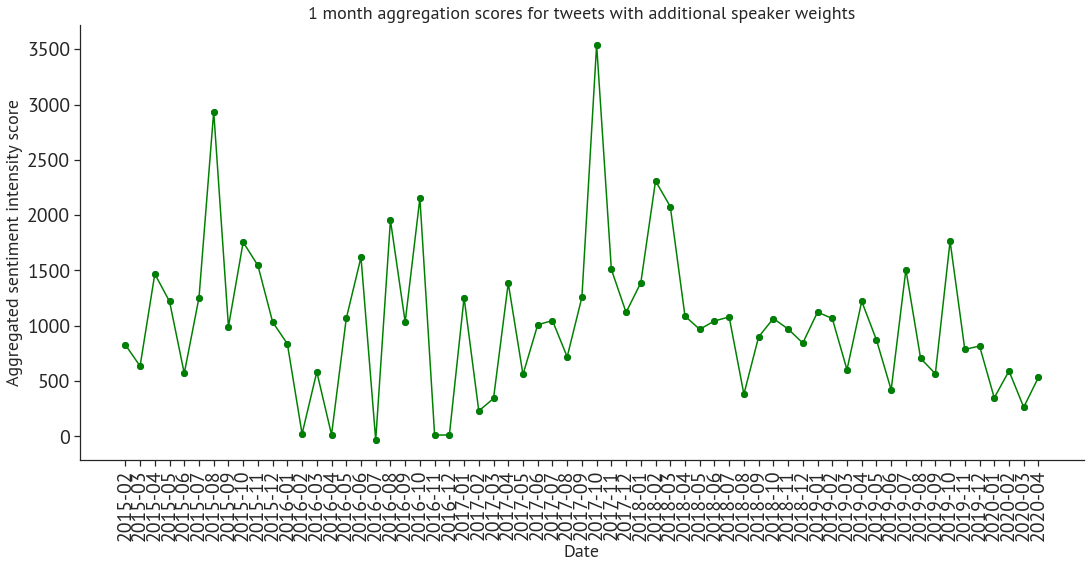

In [38]:
fig_2_sentiment, ax_2_sentiment = plt.subplots(figsize=(18,8))
result_values = []
result_mon = []
for mon, agg in zip(agg_month_speaker_weight_dates, agg_month_speaker_weight_sentiment):
    result_values.append(agg)
    result_mon.append(mon)

        

ax_2_sentiment.scatter(result_mon, result_values)

ax_2_sentiment.plot(result_mon, result_values, '-o', color='green')
plt.title('1 month aggregation scores for tweets with additional speaker weights', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Aggregated sentiment intensity score', fontsize=18)


plt.xticks(rotation=90);

<br><br>
## 1 week aggregated sentiment intensity scores
In this graph we will aggregate on each week, i.e. every 7 day we will make a data point on the graph. It is calculated counting one for each time the days change, when i reaches seven we "submit" the aggregated scores to the agg_week_sentiment list, which we will use for plotting. This way we get the aggregated scores for a 7 day period i.e. a week.

In [39]:
agg_week_sentiment_weekly = []
agg_week_dates_weekly = []
day_counter_weekly = 0
for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_day_weekly = date[:10]
        current_size_weekly = 0


    tmp_day_weekly = current_day_weekly
    current_day_weekly = date[:10] # the seven first digits of the date
    if tmp_day_weekly != current_day_weekly:
        day_counter_weekly += 1
    if day_counter_weekly == 7:
        agg_week_sentiment_weekly.append(current_size_weekly)
        agg_week_dates_weekly.append(current_day_weekly)
        current_size_weekly = 0
        day_counter_weekly = 0

    # updates weighted aggregated value of positive and negative
    current_size_weekly += row['compound']*row['numOccurrences']

    

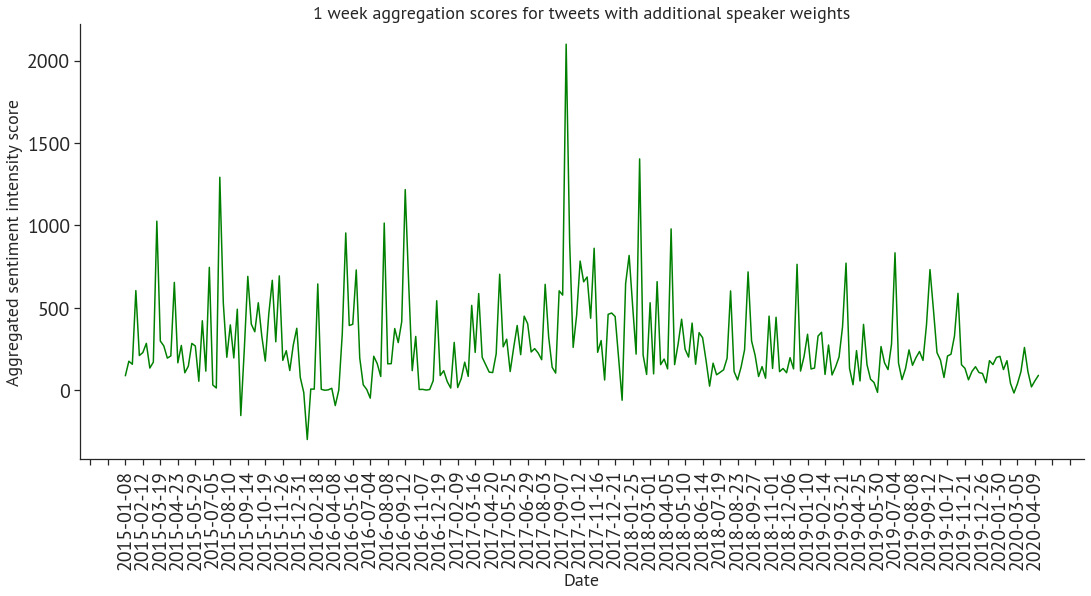

In [40]:
fig_3_sentiment, ax_3_sentiment = plt.subplots(figsize=(18,8))
result_week_values = []
result_week = []
for week, agg in zip(agg_week_dates_weekly, agg_week_sentiment_weekly):
    result_week_values.append(agg)
    result_week.append(week)

        


ax_3_sentiment.plot(result_week, result_week_values, color='green')
loc_weekly = plticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
ax_3_sentiment.xaxis.set_major_locator(loc_weekly)
plt.title('1 week aggregation scores for tweets with additional speaker weights', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Aggregated sentiment intensity score', fontsize=18)

plt.xticks(rotation=90);

<br><br>
## 1 day aggregated sentiment intensity scores
In this graph we will aggregated quotes from each day, i.e. every unique day we will make a data point on the graph. It is calculated by "submitting" the scores every time the day changes in dateframe. This way we get the aggregated scores for each unique day.

In [41]:
agg_sentiment_daily = []
agg_dates_daily = []

for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_day_daily = date[:10]
        current_size_daily = 0


    tmp_day_daily = current_day_daily
    current_day_daily = date[:10] # the seven first digits of the date
    if tmp_day_daily != current_day_daily:
        agg_sentiment_daily.append(current_size_daily)
        current_size_daily = 0
        agg_dates_daily.append(current_day_daily)

    # updates weighted aggregated value of positive and negative
    current_size_daily += row['compound']*row['numOccurrences']

    

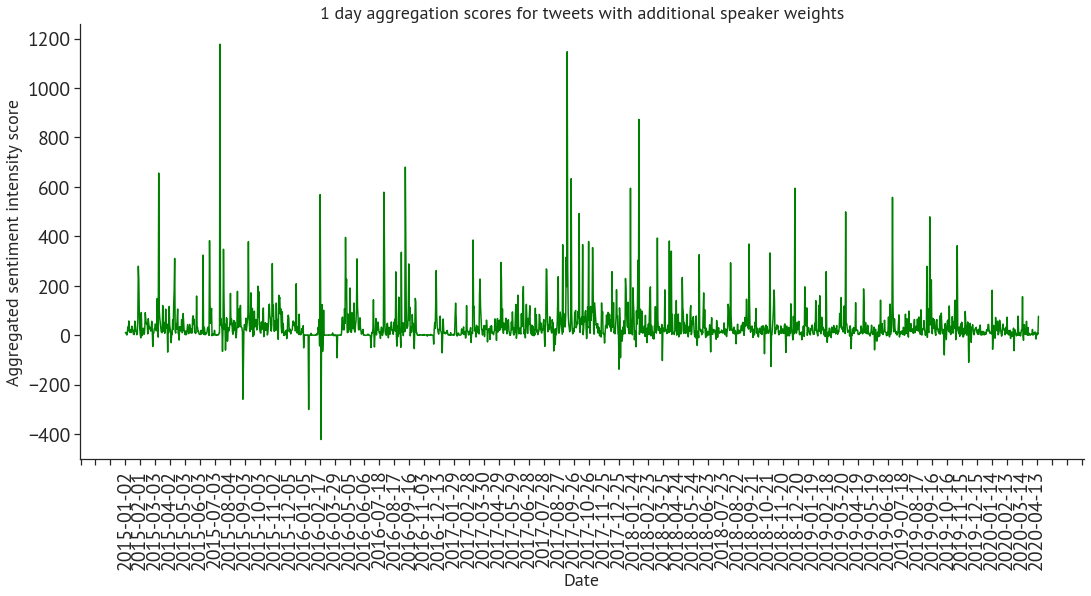

In [42]:
fig_4_sentiment, ax_4_sentiment = plt.subplots(figsize=(18,8))
result_daily_values = []
result_daily = []
for day, agg in zip(agg_dates_daily, agg_sentiment_daily):
    result_daily_values.append(agg)
    result_daily.append(day)

        



ax_4_sentiment.plot(result_daily, result_daily_values, color='green')
loc_daily = plticker.MultipleLocator(base=30) # this locator puts ticks at regular intervals
ax_4_sentiment.xaxis.set_major_locator(loc_daily)
plt.title('1 day aggregation scores for tweets with additional speaker weights', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Aggregated sentiment intensity score', fontsize=18)

plt.xticks(rotation=90);

<br><br>
## Part 3: Word cloud
In this section we will look at the word clouds for a positive and negative quotes

In [43]:
all_quotation_text = ""

for index, (idx, row) in tqdm(enumerate(sentiment_df.iterrows())):

    all_quotation_text += " " + row['quotation']

        
for string in ['Apple', 'apple', 'iPad', 'iPhone', 'Apple watch', 'apples', 'Apples', 'iPhones', ' S ', ' s ']:
    all_quotation_text = all_quotation_text.replace(string, "")



89412it [00:03, 25756.05it/s]


**Removing words that are products:**

In [44]:
stopwords = list(STOPWORDS)

### Word cloud for positive quotations

<Figure size 432x288 with 0 Axes>

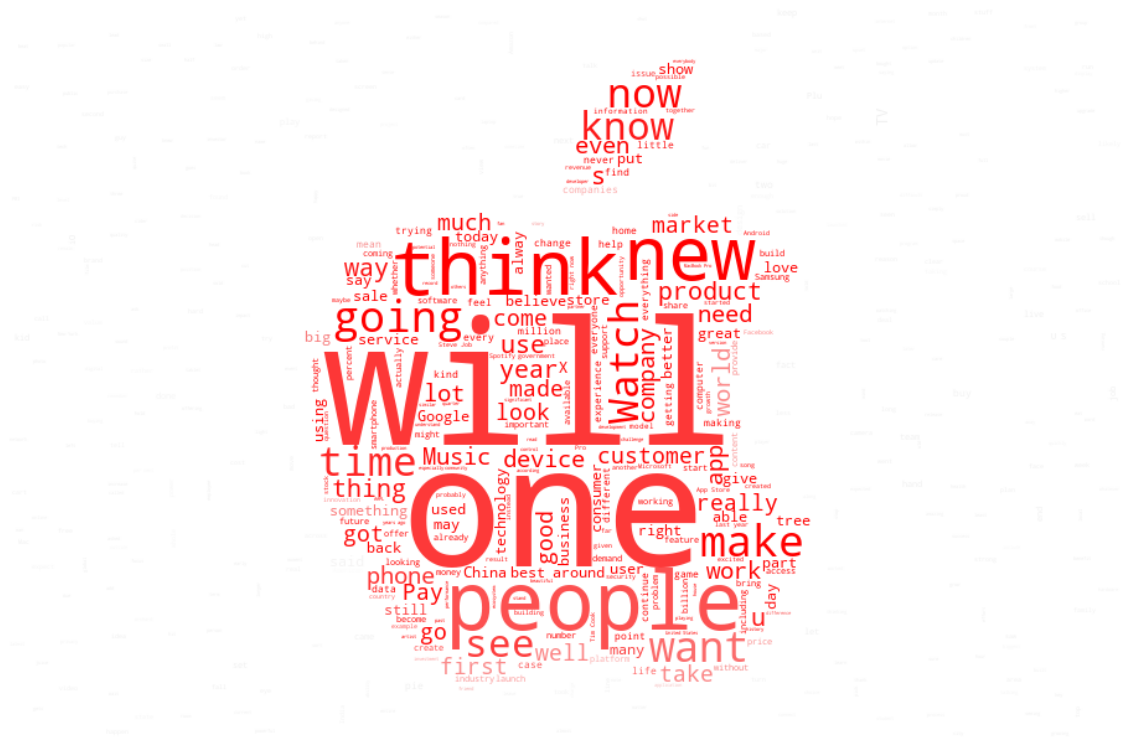

In [45]:
mask = np.array(Image.open("./data/apple_logo.png"))


word_cloud = WordCloud(stopwords=stopwords, background_color="white", mask=mask, mode="RGBA", max_words=500)
wc_all_quotes = word_cloud.generate(all_quotation_text)
plt.figure()
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wc_all_quotes.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis("off");
plt.savefig("./data/apple_word_cloud.png", format="png") 

plt.show()


<br><br><br><br><br><br>
# SECTION 3: Stock sentiment analysis

## Preprocessing of data from stock analysis

#### Load stock_data

In [46]:
stock_data=pd.read_csv('./data/AAPL_2015_to_2020_yahoo_finance.csv')
apple_event_and_stock_data=pd.read_csv('./data/events_dates_with_stock_data.csv')
apple_earnings_and_stock_data=pd.read_csv('./data/earnings_dates_with_stock_data.csv')

#### Remove unnecessary data

Remove the stock data after 16-04-2020 due to the lack of sentiment data after that date.

In [47]:
stock_data=stock_data[~(stock_data['Date'] > '2020-04-16')]
apple_event_and_stock_data=apple_event_and_stock_data[~(apple_event_and_stock_data['Date'] > '2020-04-16')]
apple_earnings_and_stock_data=apple_earnings_and_stock_data[~(apple_earnings_and_stock_data['Date'] > '2020-04-16')]

#### Convert the Date values into datetime

In [48]:
stock_data["Date"]=stock_data['Date'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d'))

### Calculate weekly average

When plotting the stock price development, we want to use the weekly average price of the stock. This is due to the missing stock data for bank holidays and weekends.

In [49]:
stock_data_weekly_average=stock_data.copy()

#Create a new dataframe containing the weekly average of the stock price.
stock_data_weekly_average.Date = pd.to_datetime(stock_data_weekly_average.Date) - pd.to_timedelta(7, unit='d')
stock_data_weekly_average = stock_data_weekly_average.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().reset_index().sort_values('Date')

### Calculate monthly change

Measurre the monthly change of the stock price. This will be used later when comparing the monthly price change and monthly sentiment score.

In [50]:
monthly_open_prize=stock_data.groupby(pd.Grouper(key='Date', freq='M')).first()['Open']
monthly_close_price=stock_data.groupby(pd.Grouper(key='Date', freq='M')).last()['Close']

stock_diff_monthly=pd.DataFrame(((monthly_close_price-monthly_open_prize)/monthly_open_prize)*100, columns=['Price_difference'])

`stock_diff_monthly` displays the monthly price change off the Apple-stock.

### Calculate weekly change

Measurre the weekly change of the stock price. This will be used later when comparing the weekly price change and weekly sentiment score.

In [51]:
weekly_open_prize=stock_data.groupby(pd.Grouper(key='Date', freq='W')).first()['Open']
weekly_close_price=stock_data.groupby(pd.Grouper(key='Date', freq='W')).last()['Close']

stock_diff_weekly=pd.DataFrame(((weekly_close_price-weekly_open_prize)/weekly_open_prize)*100, columns=['Price_difference'])

`stock_diff_weekly` displays the weekly price change off the Apple-stock.

## Preprocessing of data from sentiment analysis

#### Load the sentiment score

The sentiment score calculated in `sentiment_analysis.ipynb`is loaded to be used later in addition to the stock prices already loaded.

In [52]:
sentiment_df_section_stock = pd.read_csv('./data/sentiment_df.csv')

### Monthly sentiment

We use the same method as displayed in `sentiment_analysis.ipynb`to calculate the monthly sentiment data.

In [53]:
# Based on how much they contribute increase size of scatter plot circle
agg_month_sentiment = []
agg_month_dates = []

for index, (idx, row) in enumerate(sentiment_df_section_stock.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_month = date[:7]
        current_size = 0

    tmp_month = current_month
    current_month = date[:7] # the seven first digits of the date
    if tmp_month != current_month:
        agg_month_sentiment.append(current_size)
        current_size = 0
        agg_month_dates.append(current_month)

    # updates weighted aggregated value of positive and negative
    current_size += row['compound']*row['numOccurrences']

result_values = []
result_mon = []
for mon, agg in zip(agg_month_dates, agg_month_sentiment):
    result_values.append(agg)
    result_mon.append(mon)

We create a monthly aggregated sentiment dataframe that will be useful later when merging stock data and sentiment data.

In [54]:
sentiment_monthly = pd.DataFrame(zip(result_mon, result_values), columns =['Date', 'Sentiment_score'])
sentiment_monthly['Date'] = sentiment_monthly['Date'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m'))
sentiment_monthly.head()

,Date,Sentiment_score
0,2015-02-01,1142.3663
1,2015-03-01,788.0255
2,2015-04-01,1894.8802
3,2015-05-01,1344.7904
4,2015-06-01,815.1817


### Weekly sentiment

To make it easier to comapre the weekly sentiment to the weekly stock price, we remove the first four days of the sentiment data. This makes it easier to merge the two dataframes later.

In [55]:
sentiment_df2=sentiment_df_section_stock.copy()
sentiment_df2=sentiment_df2[~(sentiment_df2['date_clean'] < '2015-01-04')]

In [56]:
agg_week_sentiment_weekly = []
agg_week_dates_weekly = []
day_counter_weekly = 0
for index, (idx, row) in enumerate(sentiment_df2.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_day_weekly = date[:10]
        current_size_weekly = 0


    tmp_day_weekly = current_day_weekly
    current_day_weekly = date[:10] # the seven first digits of the date
    if tmp_day_weekly != current_day_weekly:
        day_counter_weekly += 1
    if day_counter_weekly == 7:
        agg_week_sentiment_weekly.append(current_size_weekly)
        agg_week_dates_weekly.append(current_day_weekly)
        current_size_weekly = 0
        day_counter_weekly = 0

    # updates weighted aggregated value of positive and negative
    current_size_weekly += row['compound']*row['numOccurrences']


result_week_values = []
result_week = []
for week, agg in zip(agg_week_dates_weekly, agg_week_sentiment_weekly):
    result_week_values.append(agg)
    result_week.append(week)

In [57]:
sentiment_weekly=pd.DataFrame(zip(result_week, result_week_values), columns =['Date', 'Sentiment_score'])
sentiment_weekly['Date'] = pd.to_datetime(sentiment_weekly['Date'])

sentiment_weekly.head()

,Date,Sentiment_score
0,2015-01-11,157.0758
1,2015-01-18,132.5439
2,2015-01-25,140.1942
3,2015-02-01,684.6362
4,2015-02-08,139.2373


## Correlation between stock and sentiment (Months)

We have now preprocessed the data and can start investigate if there exists any relationship between the stock price and the sentiment. We start by looking at the difference in monthly stock prices and compare it to the aggregated sentiment score for the same month.

### Stock price and sentiment for the current month

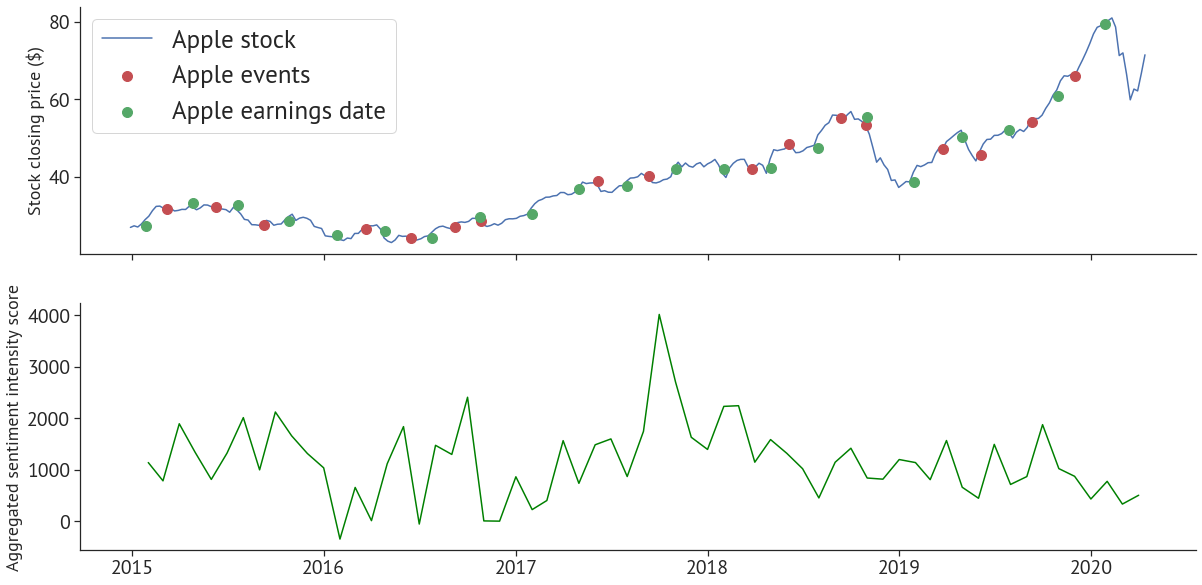

In [58]:
fig_stock_sentiment, (ax1_stock_sentiment, ax2_stock_sentiment) = plt.subplots(2, 1, sharex=True, figsize=(20,10))
ax1_stock_sentiment.plot(stock_data_weekly_average.Date, stock_data_weekly_average.Close, label='Apple stock')
ax1_stock_sentiment.set_ylabel('Stock closing price ($)', size=18)
ax1_stock_sentiment.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Close, c='r', s=100, zorder=3, label='Apple events')
ax1_stock_sentiment.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Close, c='g', s=100, zorder=3, label='Apple earnings date')
ax1_stock_sentiment.legend(prop={'size': 25})

ax2_stock_sentiment.plot(sentiment_monthly.Date, sentiment_monthly.Sentiment_score, color='green')
ax2_stock_sentiment.set_ylabel('Aggregated sentiment intensity score', fontsize=18)
plt.show();

 By just looking at the graphs, it is hard to tell if the sentiment and the stock price is related in any way. The `sentiment_monthly` use the first date of the next month to calculate sentiment, while `stock_diff_monthly` use the last day of this month used to calculate stock difference as seen below:

In [59]:
print("sentiment_monthly: " + str(sentiment_monthly.Date[0]) + ", stock_diff_monthly: " + str(stock_diff_monthly.index[0]))

sentiment_monthly: 2015-02-01 00:00:00, stock_diff_monthly: 2015-01-31 00:00:00


We substract one day from the `sentiment_monthly` such that we easily can merge the two dataframes together based on the `Date`-values.

In [60]:
sentiment_monthly['Date']=sentiment_monthly['Date']-DateOffset(days=1)

 We therefore tries to merge the two dataframes by the `Date`-column to further explore the relationships between the sentiment and price.

In [61]:
stock_price_sentiment_monthly = pd.merge(stock_diff_monthly, sentiment_monthly, how='inner', on = 'Date')

In [62]:
stock_price_sentiment_monthly.head()

,Date,Price_difference,Sentiment_score
0,2015-01-31,5.180002,1142.3663
1,2015-02-28,8.818300,788.0255
2,2015-03-31,-3.729207,1894.8802
3,2015-04-30,0.264381,1344.7904
4,2015-05-31,3.314830,815.1817


We then plot the development of the stock price and the development of the sentiment to see if we see any obvious relationships between the two.

In [63]:
sns.set_theme(style="whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False},
              font_scale=2)

Text(0, 0.5, 'Sentiment score for current month')

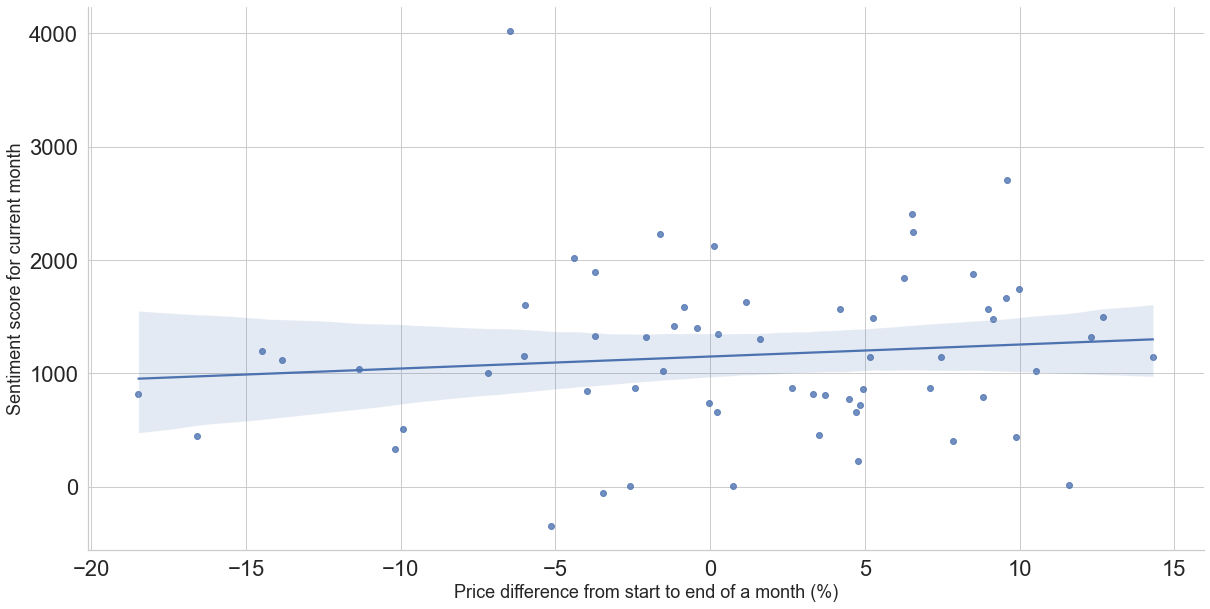

In [64]:
fig_stock_sentiment_2, ax_stock_sentiment_2=plt.subplots(figsize=(20,10))
ax_stock_sentiment_2=sns.regplot(x=stock_price_sentiment_monthly.Price_difference, y=stock_price_sentiment_monthly.Sentiment_score)
ax_stock_sentiment_2.set_xlabel('Price difference from start to end of a month (%)', size=18)
ax_stock_sentiment_2.set_ylabel('Sentiment score for current month', size=18)

We see a slightly positive relationship by looking at the correlation between the stock price and the sentiment score. From this, it might seem that it is more likely to rise in months where the Apple stock gets a lot of positive media attention. However, these findings are not very useful when predicting future stock prices because we would not know the sentiment before the end of the month.

In [65]:
correlation_coefficient, p_value=pearsonr(stock_price_sentiment_monthly.Sentiment_score, stock_price_sentiment_monthly.Price_difference)

print(f"Between monthly sentiment and monthly price difference: Correlation coefficient: {correlation_coefficient} | p-value: {p_value}")

Between monthly sentiment and monthly price difference: Correlation coefficient: 0.10863558118776057 | p-value: 0.3967089195870547


With a p-value of $0.40$, it is almost random if a stock will go up or down.

### Stock price for current month and sentiment from previous month

We now want to see if there exists a correlation between the previous month sentiment score and this months stock price. This is because such a correlation might help us say something about the most likely future development of the stock.

In [66]:
sentiment_previous_month=sentiment_monthly.copy()

#Shifts the date one month back in time
sentiment_previous_month['Date']=sentiment_previous_month['Date']-DateOffset(months=1, days=5)+MonthEnd(1)

#Merge the stock_diff_monthly with the sentiment_previous_month. Each row represent the sentiment for previous month and the stock_price for this month
stock_sentiment_previous_month=pd.merge(stock_diff_monthly, sentiment_previous_month, how='inner', on = 'Date')

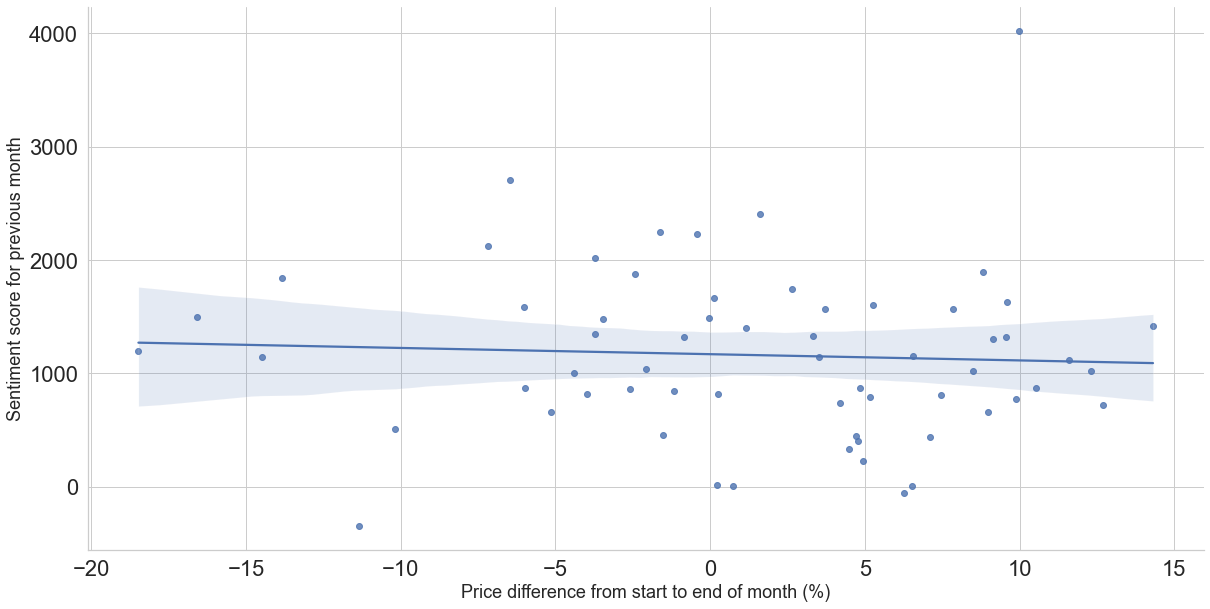

In [67]:
fig_stock_sentiment_3, ax_stock_sentiment_3=plt.subplots(figsize=(20,10))
sns.regplot(x=stock_sentiment_previous_month.Price_difference, y=stock_sentiment_previous_month.Sentiment_score)
ax_stock_sentiment_3.set_xlabel('Price difference from start to end of month (%)', size=18)
ax_stock_sentiment_3.set_ylabel('Sentiment score for previous month', size=18);

From the graph it might seem to be a negative relationship between the sentiment for the previous month and the price for this month. Based on this we can expect that a stock is more likely to increase in price following a month where we have seen a low sentiment score and vice versa. We check how likely that this relationship exists using a t-test.

In [68]:
correlation_coefficient, p_value=pearsonr(stock_sentiment_previous_month.Sentiment_score, stock_sentiment_previous_month.Price_difference)

print(f"Correlation between monthly price difference and monthly sentiment: Correlation coefficient: {correlation_coefficient} | p-value: {p_value}")

Correlation between monthly price difference and monthly sentiment: Correlation coefficient: -0.055434755831433306 | p-value: 0.6686948404760372


The test also here shows no statistically significant relationship between the prices of this month and the sentiment score from last month. We are thus still without findings when looking for a correlation between the quotes and the stock price.

#### Boxplot of the findings

In [69]:
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference']<=-15, 'Category'] = 1
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference'].between(-15,-10), 'Category'] = 2
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference'].between(-10,-5), 'Category'] = 3
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference'].between(-5,0), 'Category'] = 4
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference'].between(0,5), 'Category'] = 5
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference'].between(5,10), 'Category'] = 6
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference'].between(10,15), 'Category'] = 7
stock_sentiment_previous_month.loc[stock_sentiment_previous_month['Price_difference']>=15, 'Category'] = 8

In [70]:
sns.set_theme(style="white", rc={"axes.spines.right": False, "axes.spines.top": False},
              font_scale=2)

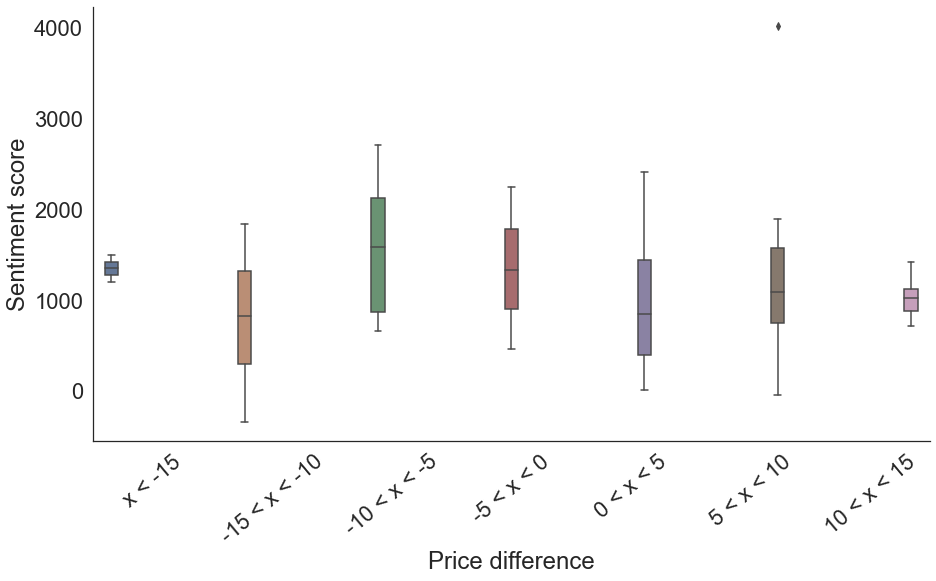

In [71]:
fig_stock_sentiment_4, ax_stock_sentiment_4 = plt.subplots(figsize=(15,8))
plot=sns.boxplot(x='Category', y='Sentiment_score', data=stock_sentiment_previous_month, hue='Category', saturation=0.5)
plt.legend([],[], frameon=False)           
ax_stock_sentiment_4.set_ylabel('Sentiment score')
ax_stock_sentiment_4.set_xlabel('Price difference')
positions = (0, 1, 2, 3, 4, 5, 6,)
labels = ('x < -15', '-15 < x < -10', '-10 < x < -5', '-5 < x < 0', '0 < x < 5', '5 < x < 10', '10 < x < 15')
plt.xticks(positions, labels, rotation=40);

### Stock price for current month and sentiment for following month

Another interesting question to look into is if a stock rises more before it gets all the media i.e. that people just hear the good news when it is already to late to buy the stock. Therefore we want to see the correlation between the stock price and its sentiment score the following month.

In [72]:
sentiment_following_month=sentiment_monthly.copy()

In [73]:
#Shifts all dates to the following month
sentiment_following_month['Date']=sentiment_following_month['Date']+DateOffset(days=5)+MonthEnd(1)

In [74]:
stock_sentiment_following_month=pd.merge(stock_diff_monthly, sentiment_following_month, how='inner', on = 'Date')

In [75]:
sns.set_theme(style="whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False},
              font_scale=2)

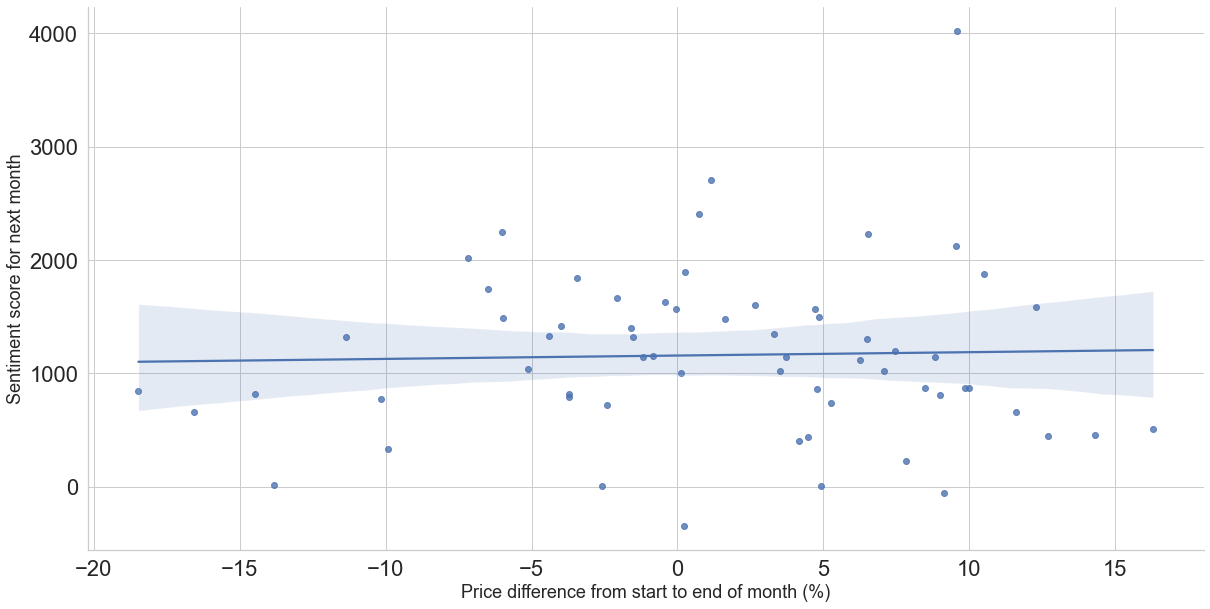

In [76]:
fig_stock_sentiment_5, ax_stock_sentiment_5=plt.subplots(figsize=(20,10))
ax_stock_sentiment_5=sns.regplot(x=stock_sentiment_following_month.Price_difference, y=stock_sentiment_following_month.Sentiment_score)
ax_stock_sentiment_5.set_xlabel('Price difference from start to end of month (%)', size=18)
ax_stock_sentiment_5.set_ylabel('Sentiment score for next month', size=18);

In [77]:
correlation_coefficient, p_value=pearsonr(stock_sentiment_following_month.Sentiment_score, stock_sentiment_following_month.Price_difference)
print(f"Between monthly price difference and sentiment following week: Correlation coefficient: {correlation_coefficient} | p-value: {p_value}")

Between monthly price difference and sentiment following week: Correlation coefficient: 0.031313280152924644 | p-value: 0.8075219325645581


Here as well, we see no relationship between price and sentiment score.

## Correlation between stock and sentiment (weeks)

So far, we have no results of interest. Therefore, we want to narrow the periods to see if they give any better results than above.

### Stock price and sentiment for current week

In [78]:
stock_sentiment_weekly = pd.merge(stock_diff_weekly, sentiment_weekly, how='inner', on = 'Date')

In [79]:
correlation_coefficient, p_value=pearsonr(stock_sentiment_weekly.Sentiment_score, stock_sentiment_weekly.Price_difference)
print(f"Correlation between monthly price difference and monthly sentiment: Correlation coefficient: {correlation_coefficient} | p-value: {p_value}")

Correlation between monthly price difference and monthly sentiment: Correlation coefficient: -0.028318978436135202 | p-value: 0.6965993069881624


### Stock price for current week and sentiment from previous week

In [80]:
sentiment_previous_week=sentiment_weekly.copy()

#Shifts the date one week back in time
sentiment_previous_week['Date']=sentiment_previous_week['Date']-DateOffset(days=7)

#Merge the sentiment_previous_week with the stock_diff_weekly. Each row represent the sentiment for previous month and the stock_price for this month
stock_sentiment_previous_week=pd.merge(stock_diff_weekly, sentiment_previous_week, how='inner', on = 'Date')

In [81]:
correlation_coefficient, p_value=pearsonr(stock_sentiment_previous_week.Sentiment_score, stock_sentiment_previous_week.Price_difference)
print(f"Correlation between weekly price difference and sentiment score the previous week: Correlation coefficient: {correlation_coefficient} | p-value: {p_value}")

Correlation between weekly price difference and sentiment score the previous week: Correlation coefficient: -0.0321576350166244 | p-value: 0.6579146605607835


### Stock price for current week and sentiment for following week

In [82]:
sentiment_following_week=sentiment_weekly.copy()

#Shifts the date one week back in time
sentiment_following_week['Date']=sentiment_following_week['Date']+DateOffset(days=7)

#Merge the sentiment_previous_week with the stock_diff_weekly. Each row represent the sentiment for previous month and the stock_price for this month
stock_sentiment_following_week=pd.merge(stock_diff_weekly, sentiment_following_week, how='inner', on = 'Date')

In [83]:
correlation_coefficient, p_value=pearsonr(stock_sentiment_following_week.Sentiment_score, stock_sentiment_following_week.Price_difference)
print(f"Correlation between weekly price difference and sentiment score the following week: Correlation coefficient: {correlation_coefficient} | p-value: {p_value}")

Correlation between weekly price difference and sentiment score the following week: Correlation coefficient: -0.16578927255781206 | p-value: 0.021552120222154175


As we can see from the p-value above, there is a significant correlation between the stock price and its sentiment the following week.

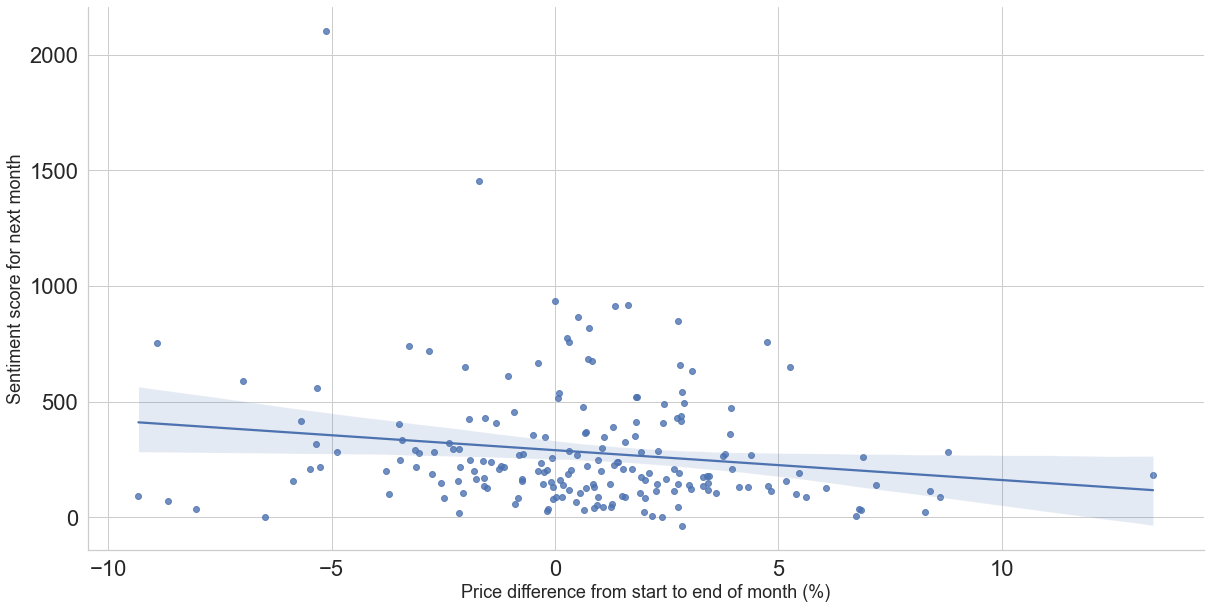

In [84]:
fig_stock_sentiment_6, ax_stock_sentiment_6=plt.subplots(figsize=(20,10))
ax_stock_sentiment_6=sns.regplot(x=stock_sentiment_following_week.Price_difference, y=stock_sentiment_following_week.Sentiment_score)
ax_stock_sentiment_6.set_xlabel('Price difference from start to end of month (%)', size=18)
ax_stock_sentiment_6.set_ylabel('Sentiment score for next month', size=18);

## Conclusion

After looking at the weekly and the monthly values of the price change and the sentiment score, we found no statistically significant correlation that can be used to predict the stock price. We found that the stock price might be used to predict the sentiment for the following week. However, this is not very useful when predicting stock prices.

<br><br><br><br><br><br>
# SECTION 4: Event analysis

## Apple product launch analysis
Loading the data and preprocessing.

In [85]:
df_event_analysis = pd.read_csv("data/quotes-2020-apple-filter.csv",sep=";")
df_event_analysis = df_event_analysis.append(pd.read_csv("data/quotes-2019-apple-filter.csv",sep=";"))
df_event_analysis = df_event_analysis.append(pd.read_csv("data/quotes-2018-apple-filter.csv",sep=";"))
df_event_analysis = df_event_analysis.append(pd.read_csv("data/quotes-2017-apple-filter.csv",sep=";"))
df_event_analysis = df_event_analysis.append(pd.read_csv("data/quotes-2016-apple-filter.csv",sep=";"))
df_event_analysis = df_event_analysis.append(pd.read_csv("data/quotes-2015-apple-filter.csv",sep=";"))

#List of dates for the apple events
apple_event_dates_str=["2015-03-09","2015-06-10","2015-09-09",
"2016-03-21","2016-06-15","2016-09-07", "2016-10-27",
"2017-06-07", "2017-09-12",
"2018-03-27","2018-06-06", "2018-09-12", "2018-10-30",
"2019-03-25","2019-06-05","2019-09-10","2019-12-02",
"2020-06-24","2020-09-15","2020-10-13","2020-11-10"]

# load sentiment dataframe
sentiment_df_event_analysis = pd.read_csv('./data/sentiment_df.csv')

#apple_event_dates_pd = pd.DataFrame({'Date':[dt.datetime.strptime(date, "%Y-%m-%d").date() for date in apple_event_dates_str]})
apple_event_dates=[dt.datetime.strptime(date, "%Y-%m-%d").date() for date in apple_event_dates_str]

# Clean the date column, such that it only contains date information and not timestamp
df_event_analysis['date_clean'] = df_event_analysis.apply(lambda x: x['date'][:10],axis=1)
df_event_analysis['date_clean_datetime'] = df_event_analysis['date_clean'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d').date())

# Clean the date column, such that it only contains date information and not timestamp
df_event_analysis['date_clean'] = df_event_analysis.apply(lambda x: x['date'][:10],axis=1)
df_event_analysis['date_clean_datetime'] = df_event_analysis['date_clean'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d').date())
sentiment_df_event_analysis['date_clean_datetime'] = sentiment_df_event_analysis['date_clean'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d').date())


# Drop outlier
df_event_analysis = df_event_analysis.drop(df_event_analysis.loc[df_event_analysis.numOccurrences == 39978].index)

In [86]:
for quote in sentiment_df_event_analysis[sentiment_df_event_analysis["date_clean"].isin(apple_event_dates_str)]["quotation"].sample(10):
    print(quote)
    print('------------------------------------------------------')

We have some great news to share with you about the future of the Apple Watch,
------------------------------------------------------
There was this kid with a guitar, he had blond hair, red apple cheeks, he was maybe 18 or 19. He had Lead Belly really pretty much down.
------------------------------------------------------
If you press the side button you can bring up your friends and you can connect Apple Watch to Apple Watch with new technology called Digital Touch.
------------------------------------------------------
Swift isn't merely the world's favorite pop star, putting up sales numbers that are nearly unfathomable in the post-Napster age -- she is also using her platform to make giant companies conform to her will. After pulling her catalogue off Spotify last year, Swift wrote an open letter to Apple asking it to pay artists during the free-trial period of its new music service. She posted the note on Tumblr on a Sunday and the company complied within hours.
----------------

Let's start by looking at how the number of apple related citations are related to product launches.

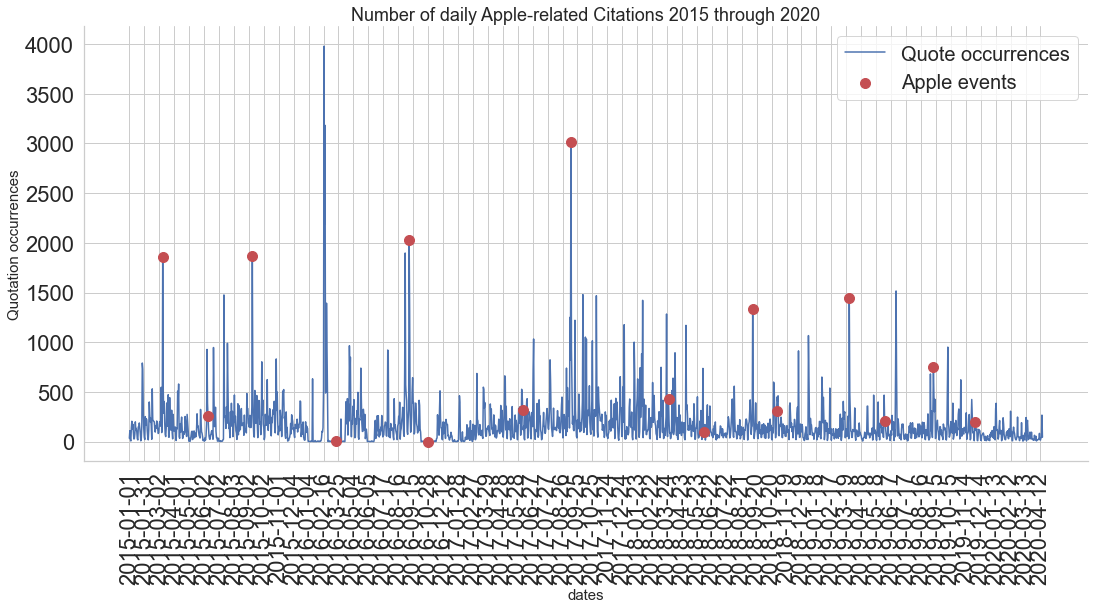

In [87]:
# slice the data frame 
time = df_event_analysis.groupby(['date_clean']).sum().index
quote_num = df_event_analysis.groupby(['date_clean']).sum()['numOccurrences']
fig_event_analysis, ax_event_analysis = plt.subplots(figsize=(18,8))
ax_event_analysis.plot(time,quote_num, label= "Quote occurrences")
ax_event_analysis.set_xlabel("dates",size=15)
ax_event_analysis.scatter(time[time.isin(apple_event_dates_str)],quote_num[time.isin(apple_event_dates_str)], c="r", s=100, zorder=3, label='Apple events')
plt.xticks(time[::30],rotation=90)
ax_event_analysis.set_ylabel("Quotation occurrences",size=15)
ax_event_analysis.set_title("Number of daily Apple-related Citations 2015 through 2020",size=18)
ax_event_analysis.legend(prop={'size': 20})
plt.show()

**Quantifying the media attention**

To quantify the media attention for a given Apple event, the following metrics are formulated:
- **Attention**: The number of weekly quote occurrences.
- **Baseline attention**: Average attention throughout the time period.
- **Event attention**: Avg. of quote occurrences through event week, prior and post week.
- **Event attention increase %**: (Event attention - Baseline attention) / Baseline attention.


To be able to compute these metrics, as well as make further analysis possible, we create the following dataframe:

*Columns:* \
Event-date, attention_week3_pre, attention_week2_pre, attention_week1_pre, attention_week0, attention_week1_post, attention_week2_post, attention_week3_post


In [88]:
df_events = pd.DataFrame()
events = []
for date in apple_event_dates:
    if (date.year == 2019 and date.month < 12) or date.year < 2020:
        events.append(date)
df_events['event_date'] = events

# group data frame by week and year to get weekly attention numbers
df_event_analysis['week'] = df_event_analysis.apply(lambda x: str(x['date_clean_datetime'].isocalendar()[1]), axis=1)
df_event_analysis['year'] = df_event_analysis.apply(lambda x: str(x['date_clean_datetime'].isocalendar()[0]), axis=1)
df_event_analysis['yearweek'] = df_event_analysis['week'] + df_event_analysis['year']
df_attention = df_event_analysis.groupby(['year','week']).sum().reset_index()


# group sentiment data frame
sentiment_df_event_analysis['week'] = sentiment_df_event_analysis.apply(lambda x: str(x['date_clean_datetime'].isocalendar()[1]), axis=1)
sentiment_df_event_analysis['year'] = sentiment_df_event_analysis.apply(lambda x: str(x['date_clean_datetime'].isocalendar()[0]), axis=1)
sentiment_week = sentiment_df_event_analysis.groupby(['year','week']).mean().reset_index()

def attention_query(date, num_weeks):
    "adds weeks to date and returns the attention the corresponding week and year"
    new_date = date + dt.timedelta(weeks=num_weeks)
    year = str(new_date.isocalendar()[0])
    week = str(new_date.isocalendar()[1])
    count = df_attention.loc[(df_attention.week == week) & (df_attention.year == year)].numOccurrences.item()
    return count

def sentiment_query(date, num_weeks):
    "adds weeks to date and returns the sentiment the corresponding week and year"
    new_date = date + dt.timedelta(weeks=num_weeks)
    year = str(new_date.isocalendar()[0])
    week = str(new_date.isocalendar()[1])
    sentiment = sentiment_week.loc[(sentiment_week.week == week) & (sentiment_week.year == year)].compound.item()
    return sentiment

# Create columns for all events
for i in [-3,-2,-1,0,1,2,3]:
    df_events[f"""attention_week{i}{'_pre' if i < 0 else '_post' if i > 0 else ''}"""] = df_events.apply(lambda x: attention_query(x['event_date'], i),axis=1)
    df_events[f"""sentiment_week{i}{'_pre' if i < 0 else '_post' if i > 0 else ''}"""] = df_events.apply(lambda x: sentiment_query(x['event_date'], i),axis=1)

attention_columns =  [ 'attention_week-3_pre', 'attention_week-2_pre',  'attention_week-1_pre', 'attention_week0','attention_week1_post', 'attention_week2_post','attention_week3_post']
sentiment_columns = ['sentiment_week-3_pre','sentiment_week-2_pre','sentiment_week-1_pre','sentiment_week0','sentiment_week1_post','sentiment_week2_post', 'sentiment_week3_post']



Let's visualize the typical distribution of media attention

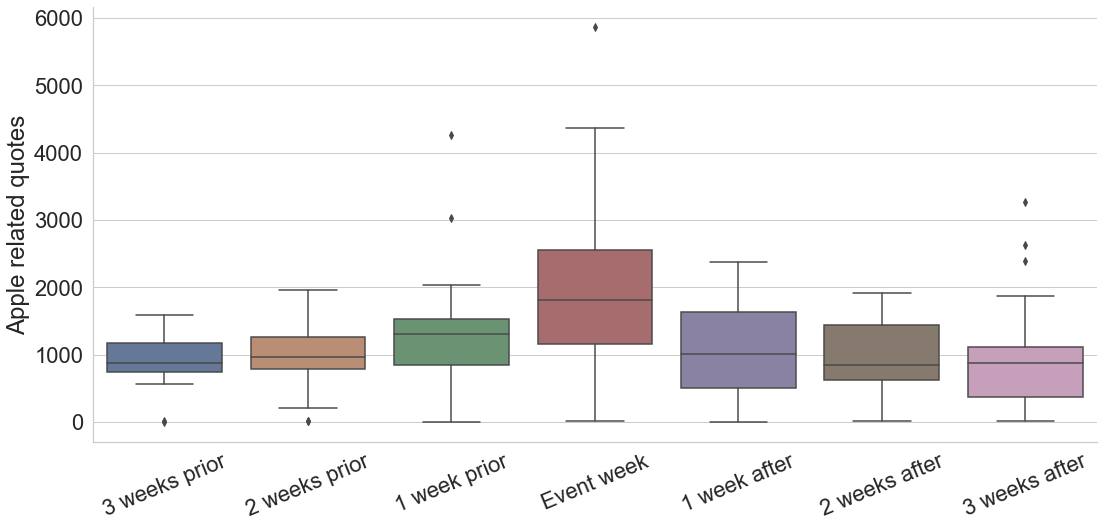

In [89]:
fig,ax = plt.subplots(figsize=(18,8))
sns.set(font_scale=2)
sns.set_theme(style="white", rc={"axes.spines.right": False, "axes.spines.top": False},
              font_scale=2)
ax = sns.boxplot(data=df_events[attention_columns],
                     saturation=0.5)
#ax.set_title("Media attention before, during and after an Apple event")
ax.set_ylabel("Apple related quotes")
positions = (0,1, 2, 3, 4, 5, 6)
labels = ("3 weeks prior", "2 weeks prior", "1 week prior","Event week", "1 week after", "2 weeks after", "3 weeks after")
plt.xticks(positions, labels, rotation=22.5);
#sns.despine(fig)


Looking at the medians, we see that the media attention rises until the week of the event where it peaks and then gradually declines in the following weeks. This shows that Apple is able to build anticipation in the media when launching new products.

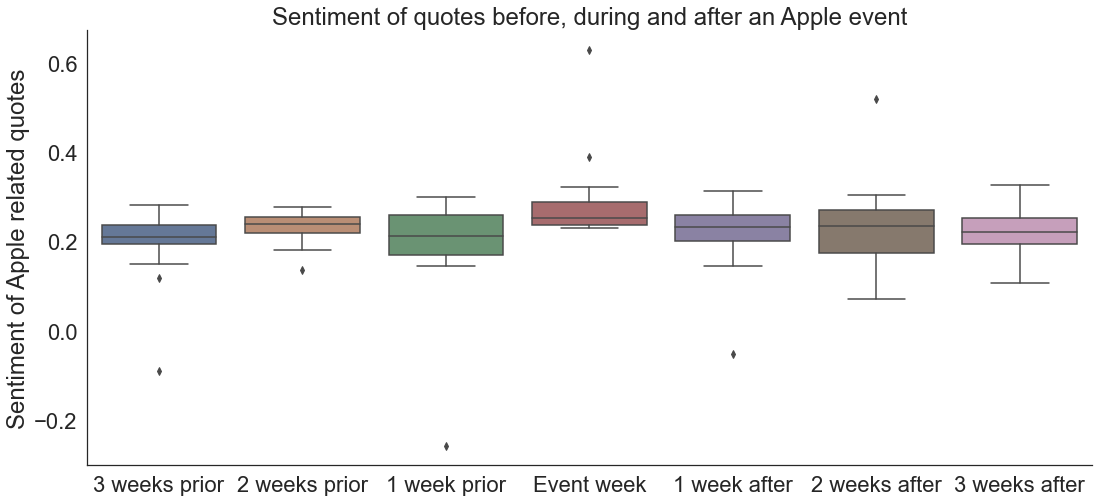

In [90]:
fig,ax = plt.subplots(figsize=(18,8))
ax = sns.boxplot(data=df_events[sentiment_columns],
                     saturation=0.5)
ax.set_title("Sentiment of quotes before, during and after an Apple event")
ax.set_ylabel("Sentiment of Apple related quotes")
positions = (0,1, 2, 3, 4, 5, 6)
labels = ("3 weeks prior", "2 weeks prior", "1 week prior","Event week", "1 week after", "2 weeks after", "3 weeks after")
plt.xticks(positions, labels);

Above we see a boxplot of the average sentiment of the quotes in the weeks prior to and after an apple event. The sentiment value ranges from -1 to 1, with 1 being very positive and -1 being very negative. Across all weeks, we see that the sentiment of the quotes typically lies around 0.2, indicidating a slight positive sentiment in the quotes but mostly neutral. Although the medians do not differ much, the median of the event week is still the highest value. From this we can conclude that Apple generally has a stable reputation in the media, with slightly positive quotes made about them on average.

In [91]:
# Compute baseline
baseline = df_attention.numOccurrences.mean()
df_events['baseline'] = baseline

# Compute average of attention in the weeks prior and after an event 
columns = ['attention_week-3_pre', 'attention_week-2_pre','attention_week-1_pre', 'attention_week0', 'attention_week1_post', 'attention_week2_post', 'attention_week3_post']
df_events['event_attention'] = df_events[columns].mean(axis=1)
df_events['attention_increase'] =  100 * (df_events.event_attention - df_events.baseline) / df_events.baseline
df_events['color'] = df_events.apply(lambda x: 'indianred' if x['attention_increase'] < 0  else 'seagreen',axis=1)
df_events

,event_date,attention_week-3_pre,sentiment_week-3_pre,attention_week-2_pre,sentiment_week-2_pre,attention_week-1_pre,sentiment_week-1_pre,attention_week0,sentiment_week0,attention_week1_post,sentiment_week1_post,attention_week2_post,sentiment_week2_post,attention_week3_post,sentiment_week3_post,baseline,event_attention,attention_increase,color
0,2015-03-09,1592,0.205073,950,0.180802,1484,0.213330,3415,0.239223,1491,0.180105,1327,0.195294,872,0.241140,1174.646209,1590.142857,35.372067,seagreen
1,2015-06-10,844,0.238879,787,0.242997,293,0.293364,1817,0.266030,1388,0.284735,1307,0.286210,56,0.215227,1174.646209,927.428571,-21.046136,indianred
2,2015-09-09,1377,0.268644,1550,0.220960,1469,0.193604,3200,0.234183,1979,0.223281,1715,0.248565,1879,0.261230,1174.646209,1881.285714,60.157646,seagreen
3,2016-03-21,13,0.150282,14,0.191808,13,0.258775,21,0.388664,11,-0.052400,233,0.071750,12,0.121709,1174.646209,45.285714,-96.144736,indianred
4,2016-06-15,1181,0.195502,207,0.254150,7,-0.256371,9,0.628667,5,0.195940,514,0.118771,977,0.184652,1174.646209,414.285714,-64.731022,indianred
5,2016-09-07,1300,0.233880,1270,0.267545,4266,0.170580,4366,0.288352,2370,0.258917,1491,0.229842,1114,0.255799,1174.646209,2311.000000,96.740089,seagreen
6,2016-10-27,3,-0.089533,9,0.263886,16,0.261529,21,0.254050,2,0.278700,9,0.520300,18,0.106510,1174.646209,11.142857,-99.051386,indianred
7,2017-06-07,875,0.229775,973,0.277313,1478,0.160007,1654,0.238226,1634,0.226762,1435,0.238627,2385,0.221446,1174.646209,1490.571429,26.895351,seagreen
8,2017-09-12,1419,0.237112,1823,0.266726,3024,0.222283,5872,0.263193,2161,0.233814,1680,0.213406,2633,0.197567,1174.646209,2658.857143,126.353869,seagreen
9,2018-03-27,1090,0.200885,1961,0.219306,2037,0.229726,1244,0.235145,1738,0.254578,1921,0.234388,1106,0.200995,1174.646209,1585.285714,34.958569,seagreen


###

Now looking at how different apple events have deviated from the attention average

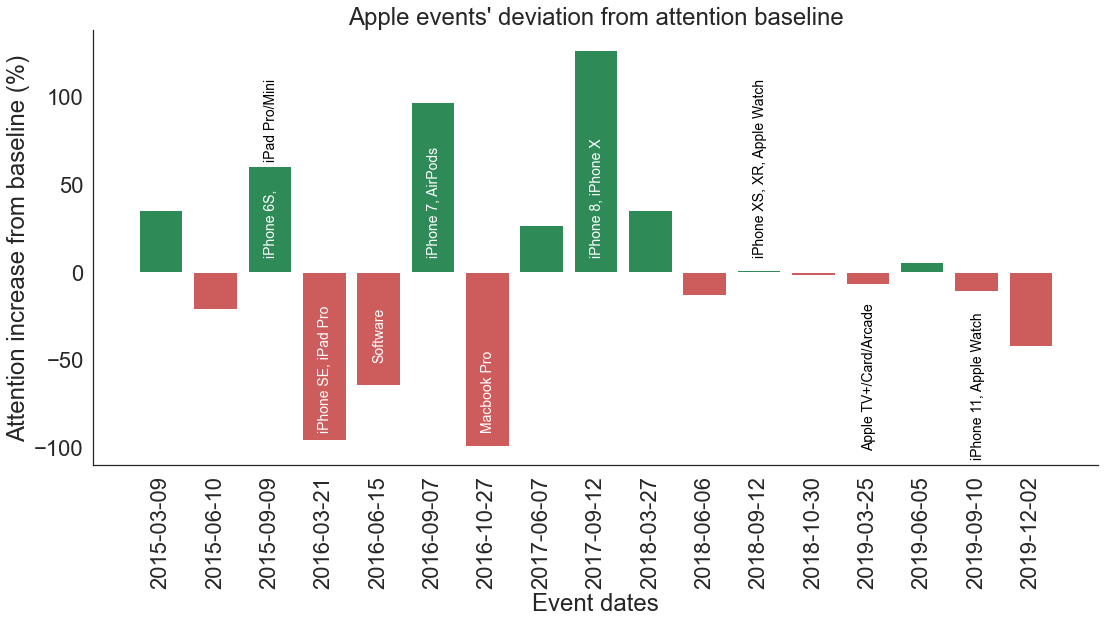

In [92]:
fig,ax = plt.subplots(figsize=(18,8))
plt.bar(x=apple_event_dates_str[:17],height=df_events.attention_increase,color=df_events.color)
plt.xticks(rotation=90)
plt.xlabel("Event dates")
plt.ylabel("Attention increase from baseline (%)")
plt.title("Apple events' deviation from attention baseline")
plt.text(10.9, 10, "iPhone XS, XR, Apple Watch", fontsize=14,rotation=90,color="black")
plt.text(7.9, 10, "iPhone 8, iPhone X", fontsize=14,rotation=90,color="white")
plt.text(4.9, 10, "iPhone 7, AirPods", fontsize=14,rotation=90,color="white")
plt.text(1.9, 10, "iPhone 6S,", fontsize=14,rotation=90,color="white")
plt.text(1.9, 65, "iPad Pro/Mini", fontsize=14,rotation=90,color="black")
plt.text(5.9, -90, "Macbook Pro", fontsize=14,rotation=90,color="white");
plt.text(2.9, -90, "iPhone SE, iPad Pro", fontsize=14,rotation=90,color="white");
plt.text(3.9, -50, "Software", fontsize=14,rotation=90,color="white");
plt.text(12.9, -100, "Apple TV+/Card/Arcade", fontsize=14,rotation=90,color="black");
plt.text(14.9, -105, "iPhone 11, Apple Watch", fontsize=14,rotation=90,color="black");

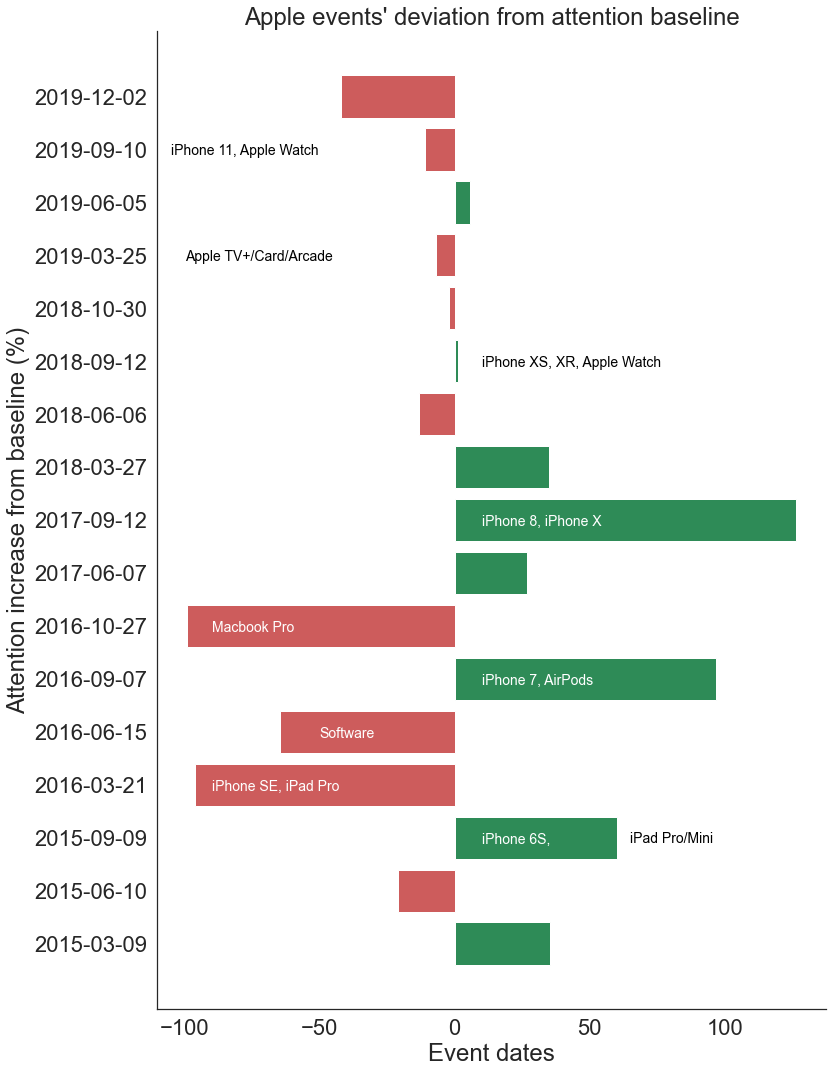

In [93]:
fig,ax = plt.subplots(figsize=(12,18))
plt.barh(y=apple_event_dates_str[:17],width=df_events.attention_increase,color=df_events.color)
#plt.xticks(rotation=90)
plt.xlabel("Event dates")
plt.ylabel("Attention increase from baseline (%)")
plt.title("Apple events' deviation from attention baseline")
plt.text(10, 10.9, "iPhone XS, XR, Apple Watch", fontsize=14, color="black")
plt.text(10, 7.9, "iPhone 8, iPhone X", fontsize=14,color="white")
plt.text(10, 4.9, "iPhone 7, AirPods", fontsize=14,color="white")
plt.text(10, 1.9, "iPhone 6S,", fontsize=14,color="white")
plt.text(65, 1.9, "iPad Pro/Mini", fontsize=14,color="black")
plt.text(-90, 5.9, "Macbook Pro", fontsize=14,color="white");
plt.text(-90, 2.9, "iPhone SE, iPad Pro", fontsize=14,color="white");
plt.text(-50, 3.9, "Software", fontsize=14,color="white");
plt.text(-100, 12.9, "Apple TV+/Card/Arcade", fontsize=14,color="black");
plt.text(-105, 14.9, "iPhone 11, Apple Watch", fontsize=14,color="black");

## Does the sentiment of quarter earning announcements differ from product launches?

In [94]:
quarterly_earnings=pd.read_excel('./data/Earnings_Apple.xlsx')

#Remove the unnecessary rows in the quarterly_earnings
quarterly_earnings=quarterly_earnings.drop(index=[0,1,2,3,4,5,6,7])

#Change the format of the Earnings Date column
quarterly_earnings["Earnings Date"]=quarterly_earnings["Earnings Date"].map(lambda x: x.replace(", 12 AMEST", "").replace(",", ""))
quarterly_earnings["Earnings Date"]=quarterly_earnings["Earnings Date"].map(lambda x: dt.datetime.strptime(x, "%b %d %Y"))

#Clean surprise factor\n",
quarterly_earnings["Surprise(%)"] = quarterly_earnings["Surprise(%)"].map(lambda x: -1*x[1:] if x[0] == '-' else x[1:])

# Remove dates before 2020\n",
to_drop = []
for i, date in enumerate(quarterly_earnings["Earnings Date"]):
    if date.year > 2019:
        to_drop.append(i+8)
quarterly_earnings = quarterly_earnings.drop(index=to_drop,axis=0)

# Add sentiment columns\n"
for i in [-3,-2,-1,0,1,2,3]:
    quarterly_earnings[f"""sentiment_week{i}{'_pre' if i < 0 else '_post' if i > 0 else ''}"""] = quarterly_earnings.apply(lambda x: sentiment_query(x['Earnings Date'], i),axis=1)

Text(0.5, 1.0, 'Comparison of mean sentiment for product launches and earning announcements')

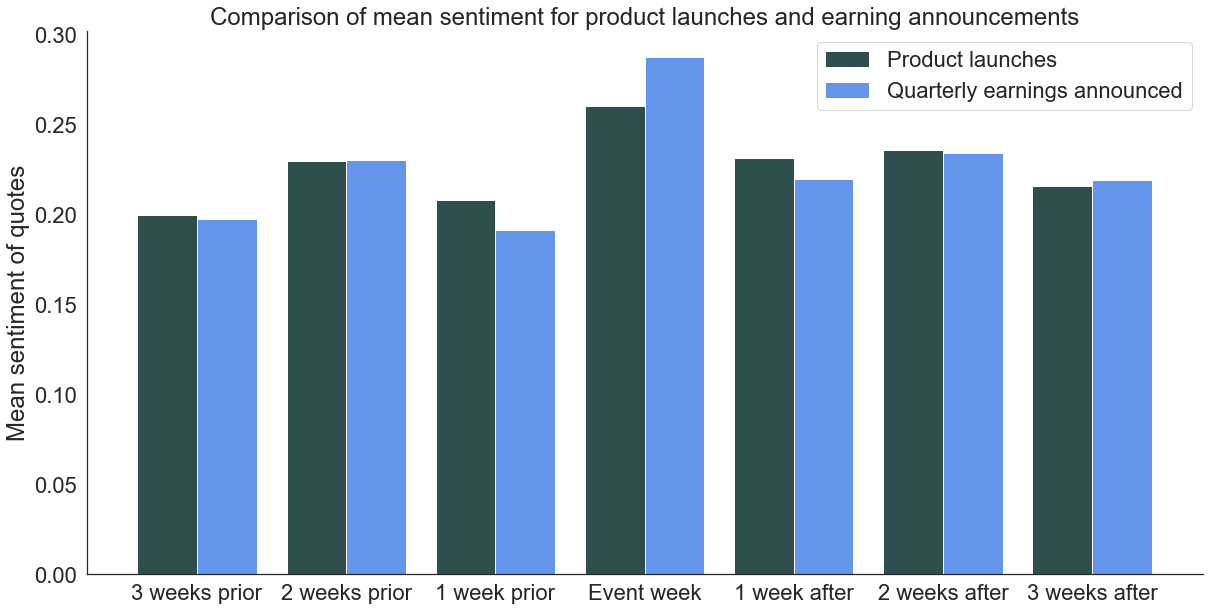

In [95]:
a = quarterly_earnings[sentiment_columns].mean().tolist()
b = df_events[sentiment_columns].mean().tolist()

# plot data in grouped manner of bar type\n",
plt.subplots(figsize=(20,10))
x = np.arange(7)
width = 0.4
plt.bar(x-0.2, a, width,color='darkslategrey')
plt.bar(x+0.2, b, width,color='cornflowerblue')
plt.xticks(x,labels)
plt.legend(['Product launches', 'Quarterly earnings announced'])
plt.ylabel("Mean sentiment of quotes")
plt.title("Comparison of mean sentiment for product launches and earning announcements")


Looking at the plot above, it can be seen that the sentiment of quotes before and after product launches on average are very similar the sentiment of quotes before and after announcements of quarterly earnings. The quotes are, however, generally more positive in the weeks where quarterly earnings are announced than in the weeks where new products are launched. This can be explained by the fact that quarterly reports typically are described with more adjectives, whereas product launches may be more factual and thus neutral.

Text(0, 0.5, 'Mean sentiment of quotes')

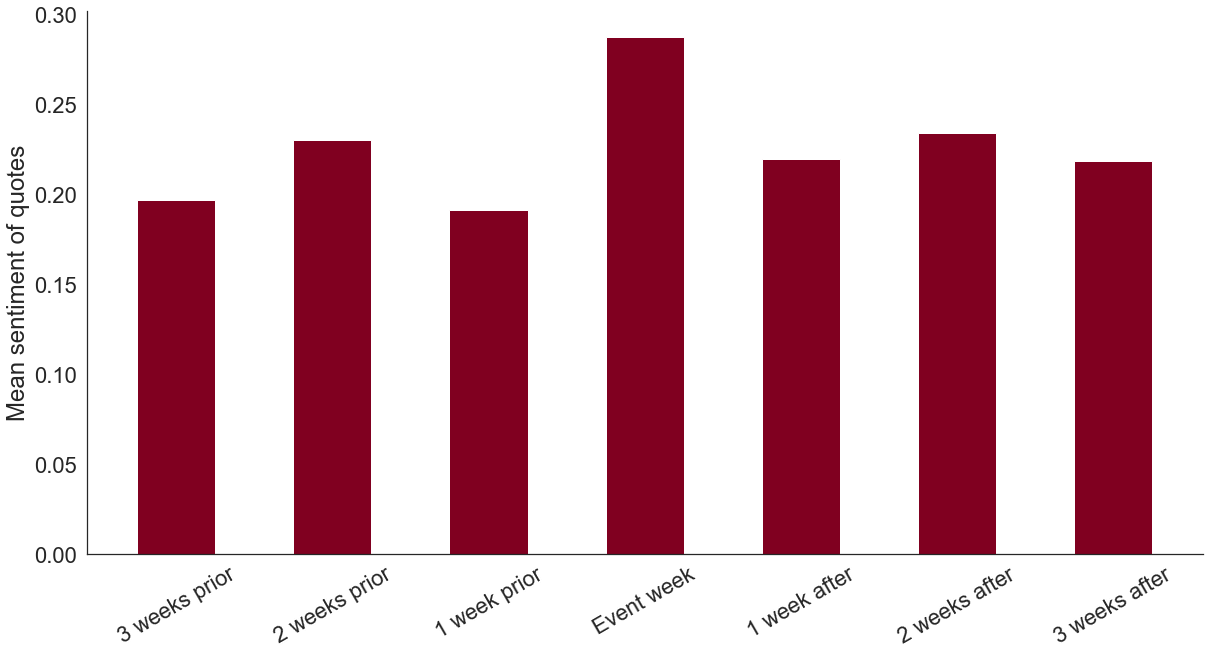

In [96]:

b = df_events[sentiment_columns].mean().tolist()

# set theme of plot
sns.set_theme(style='white', rc={'axes.spines.right': False, 'axes.spines.top': False}, font='Arial', font_scale=2)
# plot data in grouped manner of bar type\n",
plt.subplots(figsize=(20,10))
x = np.arange(7)
width = 0.5
#plt.bar(x-0.2, a, width,color='darkslategrey')
plt.bar(x, b, width,color='#800020')
plt.xticks(x,labels, rotation=30)
#plt.legend(['Product launches', 'Quarterly earnings announced'])
plt.ylabel("Mean sentiment of quotes")
#plt.title("Comparison of mean sentiment for product launches and earning announcements")

From the plot it is clear that the not only the attention, but also the sentiment towards Apple increases during an event week. In addition the plot indicates that the sentiment in the weeks after an event is more positive than the weeks prior. To investigate this we will perform a Mann Whitney U-test, a robust, non-parametric test which measures whether there exist a significant difference between to distributions. 

Source: [Towards Data Science](https://towardsdatascience.com/intro-to-data-science-part-3-data-analysis-71a566c3a8c3)

In [97]:
df_events.columns

Index(['event_date', 'attention_week-3_pre', 'sentiment_week-3_pre',
       'attention_week-2_pre', 'sentiment_week-2_pre', 'attention_week-1_pre',
       'sentiment_week-1_pre', 'attention_week0', 'sentiment_week0',
       'attention_week1_post', 'sentiment_week1_post', 'attention_week2_post',
       'sentiment_week2_post', 'attention_week3_post', 'sentiment_week3_post',
       'baseline', 'event_attention', 'attention_increase', 'color'],
      dtype='object')

In [98]:
# Make numpy representations of weeks prior to event, and posterior to event
pre_columns = ['sentiment_week-3_pre', 'sentiment_week-2_pre', 'sentiment_week-1_pre']
post_columns = ['sentiment_week3_post', 'sentiment_week2_post', 'sentiment_week1_post']

prior_weeks = np.mean(df_events[pre_columns], axis=1)
posterior_weeks = np.mean(df_events[post_columns], axis=1)
event_week = df_events["sentiment_week0"]

# Combine prior and posterior to represent all weeks except event week
prior_posterior = np.array([prior_weeks, posterior_weeks]).T

# Conduct test between weeks prior and posterior
test_result = mannwhitneyu(prior_weeks, posterior_weeks)

print(f'Sentiment for the three weeks prior to a launch:')
print(f'Mean: {prior_weeks.mean()}, Standard Deviation: {prior_weeks.std()}')
print('----------------------------------------------------------------------')
print(f'Sentiment for the three weeks posterior to a launch:')
print(f'Mean: {posterior_weeks.mean()}, Standard Deviation: {posterior_weeks.std()}')
print('----------------------------------------------------------------------')
print(f'Mann Whitney U-Test: {test_result}')

# Conduct test between event week and all other
event_rest = mannwhitneyu(prior_posterior.mean(axis=1), event_week)
print('----------------------------------------------------------------------')
print(f'Sentiment for event week:')
print(f'Mean: {posterior_weeks.mean()}, Standard Deviation: {posterior_weeks.std()}')
print('----------------------------------------------------------------------')
print(f'Mann Whitney U-Test between event week and all other: {event_rest}')

Sentiment for the three weeks prior to a launch:
Mean: 0.20627618746342166, Standard Deviation: 0.04871004184738456
----------------------------------------------------------------------
Sentiment for the three weeks posterior to a launch:
Mean: 0.22426916117447848, Standard Deviation: 0.05900636970657237
----------------------------------------------------------------------
Mann Whitney U-Test: MannwhitneyuResult(statistic=113.0, pvalue=0.28563352706656997)
----------------------------------------------------------------------
Sentiment for event week:
Mean: 0.22426916117447848, Standard Deviation: 0.05900636970657237
----------------------------------------------------------------------
Mann Whitney U-Test between event week and all other: MannwhitneyuResult(statistic=38.0, pvalue=0.00026120660215923273)


Mann Whitney U-test that the two distributions are equal. The p-value represents the percentages of times we would see a similar (or more extreme) result as our obeservations given this assumption. Since the p-value is ~0.3, by drawing two random samples from the same distribution would yield at least as big difference as observed. This difference is not significant.

### Does the sentiment/attention before and after a product launch correlate with changes in the stock price?

In [99]:
# Calculate sentiment change for each of the product launches
df_events['sentiment_change'] = df_events["sentiment_week1_post"] - df_events['sentiment_week-1_pre']
df_events['attention_change'] = df_events["attention_week1_post"] - df_events['attention_week-1_pre']


# Calculate the change in stock price before and after each stock price (average of the week before to the week after)
stock_data_events=pd.read_csv('./data/AAPL_2015_to_2020_yahoo_finance.csv')
stock_data_events.Date = pd.to_datetime(stock_data_events.Date) - pd.to_timedelta(7, unit='d')
stock_data_events = stock_data_events.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().reset_index().sort_values('Date')
stock_data_events['week'] = stock_data_events.apply(lambda x: x['Date'].week,axis=1)
stock_data_events['year'] = stock_data_events.apply(lambda x: x['Date'].year,axis=1)

def stock_query(date):
    "Given date returns the difference between the stockprice the week before and after said date"
    year = date.isocalendar()[0]
    week = date.isocalendar()[1]
    stock_start = stock_data_events.loc[(stock_data_events.week == week - 1) & (stock_data_events.year == year)].Open.item()
    stock_end = stock_data_events.loc[(stock_data_events.week == week + 1) & (stock_data_events.year == year)].Close.item()

    diff = stock_start - stock_end
    return diff


df_events["stock_change"] = df_events.apply(lambda x: stock_query(x['event_date']),axis=1)

Let's see if there is any connection between the change in stock price and sentiment/attention

Text(0, 0.5, 'Difference in attention score after product launch ')

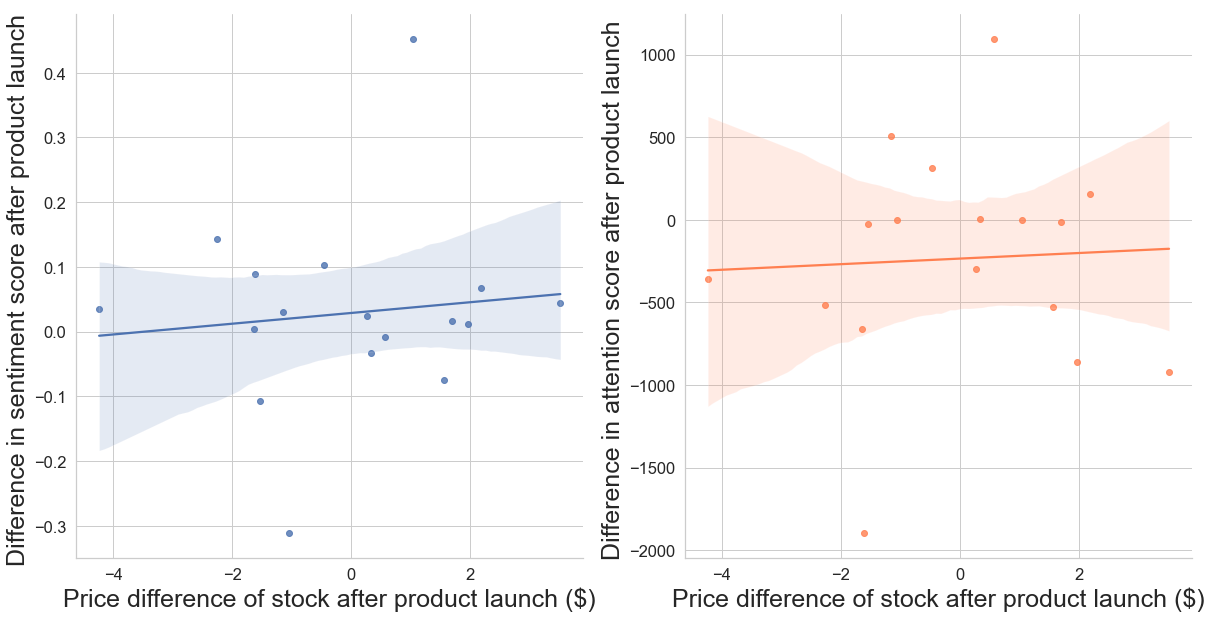

In [100]:
sns.set_theme(font_scale=1.5, style='whitegrid', font='Arial', rc={"axes.spines.right": False, "axes.spines.top": False})
fig, axes =plt.subplots(1,2,figsize=(20,10))
sns.set_theme(style='white', rc={'axes.spines.right': False, 'axes.spines.top': False}, font_scale=2)
sns.regplot(ax=axes[0], x=df_events["stock_change"], y=df_events["sentiment_change"])
axes[0].set_xlabel('Price difference of stock after product launch ($)', size=25)
axes[0].set_ylabel('Difference in sentiment score after product launch ', size=25)
sns.regplot(ax=axes[1],x=df_events["stock_change"], y=df_events["attention_change"],color='coral')
axes[1].set_xlabel('Price difference of stock after product launch ($)', size=25)
axes[1].set_ylabel('Difference in attention score after product launch ', size=25)

#fig.suptitle('Does changes in sentiment/attention after a product launch correlate with changes in stock prices?')

In [101]:
import statsmodels.api as sm
mod = sm.OLS(df_events["stock_change"],df_events["sentiment_change"])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:           stock_change   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):             -0.051
Method:                 Least Squares   F-statistic:                             0.1703
Date:                Fri, 17 Dec 2021   Prob (F-statistic):                       0.685
Time:                        17:01:33   Log-Likelihood:                         -34.933
No. Observations:                  17   AIC:                                      71.87
Df Residuals:                      16   BIC:                                      72.70
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

/Users/fritt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [102]:
mod = sm.OLS(df_events["stock_change"],df_events["attention_change"])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:           stock_change   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):             -0.059
Method:                 Least Squares   F-statistic:                            0.04802
Date:                Fri, 17 Dec 2021   Prob (F-statistic):                       0.829
Time:                        17:01:33   Log-Likelihood:                         -34.998
No. Observations:                  17   AIC:                                      72.00
Df Residuals:                      16   BIC:                                      72.83
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

/Users/fritt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Both regression lines have very low R^2-values indicating a poor fit. To conclude, the change in stock price from the week before an event to the week after an event can neither be explained by the corresponding change in attention level nor the change in sentiment.